# Importing Necessary Libraries

In [1]:
%matplotlib notebook

import math
import time
from collections import deque

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load up the data
## AMD stock prices dataset
<br>Data from [Yahoo Finance](https://finance.yahoo.com/) and it contains **AMD** and **GOOGLE** daily historical price, starting from 2009 to 2018.
<br>You can find the data [here](https://www.kaggle.com/gunhee/amdgoogle)

In [2]:
amd_df = pd.read_csv("AMD.csv")
amd_df.head()

Date  Open  High   Low  Close  Adj Close    Volume
0  2009-05-22  4.43  4.43  4.25   4.26       4.26   8274300
1  2009-05-26  4.26  4.57  4.23   4.53       4.53  16094300
2  2009-05-27  4.57  4.80  4.55   4.71       4.71  21512600
3  2009-05-28  4.75  4.84  4.54   4.70       4.70  18383900
4  2009-05-29  4.71  4.78  4.38   4.54       4.54  24539700

In [3]:
amd_df = amd_df[['Date','Close']]
amd_df.head()

Date  Close
0  2009-05-22   4.26
1  2009-05-26   4.53
2  2009-05-27   4.71
3  2009-05-28   4.70
4  2009-05-29   4.54

Drop the date column.

In [4]:
amd_df.drop(['Date'], axis=1, inplace=True)
amd_df.head()

Close
0   4.26
1   4.53
2   4.71
3   4.70
4   4.54

In [5]:
amd_df.rename(columns={'Close':'Price'}, inplace=True)
amd_df.head()

Price
0   4.26
1   4.53
2   4.71
3   4.70
4   4.54

Drop Nan values.

In [6]:
print("Before dropping Nan values: ", len(amd_df))

Before dropping Nan values:  2335


In [7]:
amd_df.dropna(inplace=True)

In [8]:
print("After dropping Nan values: ", len(amd_df))

After dropping Nan values:  2335


## Plot the data

<IPython.core.display.Javascript object>


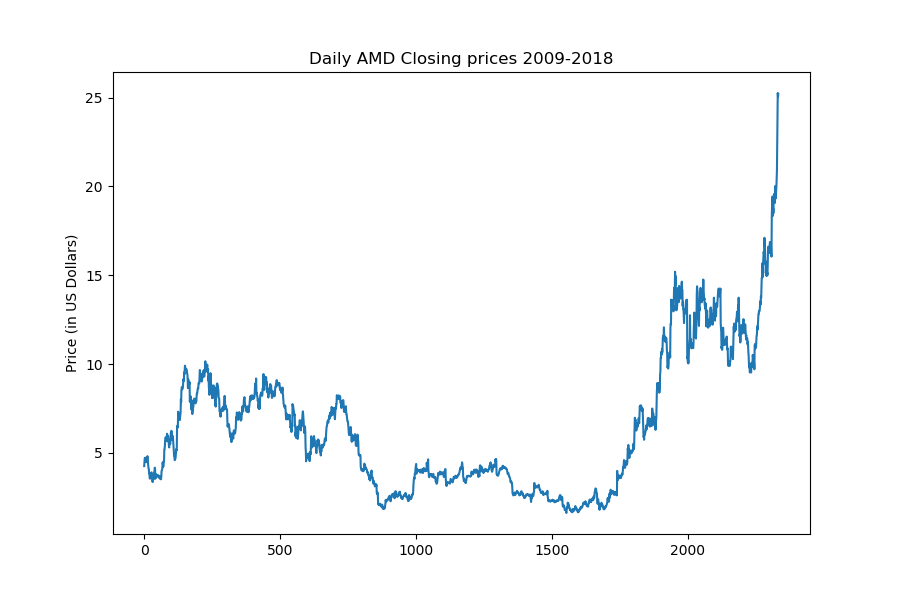

In [9]:
plt.figure(figsize=(9,6))
plt.plot(amd_df.index, amd_df)
plt.title("Daily AMD Closing prices 2009-2018")
plt.ylabel("Price (in US Dollars)")
plt.show()

# Data Preprocessing

These functions will be used to scale, generate sequences, and split our sequential data in order to prepare it for input to an LSTM Keras model.

This function is for scaling the data.
<br>**Note:** we need to scale because if we fit the model on unscaled data that has a wide range of values, then it is possible for large inputs to slow down the learning and convergence of our network and in some cases prevent the network from effectively learning your problem.

In [10]:
def scale_data(input_3d_array):
    """
    This function transforms the values of a 3D numpy array using MinMaxScaler from sklearn.model_selection
    """
    original_shape = input_3d_array.shape
    # Reshaping the the array in order to make it 2-Dimensional array
    # since fit_transform function accepts only 2D array as an input parameter.
    input_3d_array = input_3d_array.reshape(input_3d_array.shape[0],input_3d_array.shape[1])
    # Transforming the values.
    input_3d_array = min_max_scaler.fit_transform(input_3d_array)
    # Reshaping the array back to its original shape.
    input_3d_array = input_3d_array.reshape(original_shape)
    
    return input_3d_array

This function will be used to generate input sequences which consists of (X,y) arrays, where:
<br> X : the prices of the days preceding the target day (the day that we want to predict the price for).
<br> y : the price on target day.

In [11]:
def preprocess_data(data_array, window):
    """
    This method takes a numpy array as input, and returns X,y numpy arrays as the output.
    N = len(data)
    X (data_array) = shape(N-window,window,1)
    y = shape(N-window,1)
    """
    X = []
    y = []
    SEQ_LEN = window
    # the prices of a number of squential days equal to the window parameter
    prev_days = deque(maxlen=SEQ_LEN)
    for index,item in enumerate(data_array[:-1]):
        prev_days.append(item)
        if len(prev_days) == SEQ_LEN:
            X.append(np.array(prev_days))
            y.append(data_array[index+1])
    
    return np.array(X), np.array(y)

This function will be used for splitting the data into training and testing sets.

In [12]:
def split_data_no_validation(X_main, y_main, test_size):
    """
    This function returns training and testing data based on the wanted split size. as follows:
    output: X_train, X_test, y_train, y_test (Numpy arrays)
    The arguments:
    X_main: inputs (a Numpy array)
    y_main: targets (a Numpy array)
    split_size: float ex. 0.1 means 10% for testing and 90% for training
    """
        
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

# Saving some input samples to test the trained models

We are going to train **6 models** in order to experiment the different resutls and pick out what is best. Concretely, these are the characteristics that we are going to build the models on:
* Save **100** input samples from the last part of the data. **(70% training data, 30% testing data)**
* Save **100** input samples. **(50% training, 50% testing)**
* Save **1000** input samples **(70% training, 30% testing)**
* Save **1000** input samples **(50% training, 50% testing)**
* Save **2000** input samples **(70% training, 30% testing)**
* Save **2000** input samples **(50% training, 50% testing)**

Using MinMaxScaler provided by Scikit-learn in order to scale the data into the range (0,1).

In [13]:
min_max_scaler = MinMaxScaler()
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

The following method will be used for creating the input and output sample arrays that are going to be used later for testing
the model.

In [14]:
def create_input_and_output_sample(df, input_sample_length, window):
    """
    This method takes a dataframe, an input sample length which is the number of days that we want to predict from the last
    part of the given dataframe, and window which is the number of consecutive days that we will look at before each day
    that we will predict.
    """
    # take the last necessary part of the dataframe
    index = input_sample_length + window
    df = df[-index:]
    # scale the data
    scaled_df = scale_data(df.values)
    # getting the input_sample and output_sample
    X, y = preprocess_data(scaled_df, window)
    
    print(f"input sample length: {input_sample_length}, window: {window}")
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    
    return X, y

Extract the (X,y) Numpy arrays from the last part of the data to use it to evaluate the the models.

In [15]:
X_test_sample_100, y_test_sample_100 = create_input_and_output_sample(df=amd_df, input_sample_length=100, window=10)
X_test_sample_1000, y_test_sample_1000 = create_input_and_output_sample(df=amd_df, input_sample_length=1000, window=10)
X_test_sample_2000, y_test_sample_2000 = create_input_and_output_sample(df=amd_df, input_sample_length=2000, window=10)

input sample length: 100, window: 10
Shape of X: (100, 10, 1), shape of y: (100, 1)
input sample length: 1000, window: 10
Shape of X: (1000, 10, 1), shape of y: (1000, 1)
input sample length: 2000, window: 10
Shape of X: (2000, 10, 1), shape of y: (2000, 1)


In [16]:
len(amd_df)

2335

Let's extract the data that will be used for generating sequences and fitting the model excluding the last 100, 1000, 2000 days respectively. Concretely:
<br>df_100_70 : This data frame will be used to fit (70% training, 30% testing) model with last 100 days excluded from the original data.
<br>df_100_50 : This data frame will be used to fit (50% training, 50% testing) model with last 100 days excluded from the original data.
<br>df_1000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 1000 days excluded from the original data.
<br>df_1000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 1000 days excluded from the original data.
<br>df_2000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 2000 days excluded from the original data.
<br>df_2000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 2000 days excluded from the original data.

In [17]:
df_100_70 = amd_df[:-100] # the rest of the data that we are going to use for training and testing
df_100_50 = amd_df[:-100] # the rest of the data that we are going to use for training and testing

df_1000_70 = amd_df[:-1000] # the rest of the data that we are going to use for training and testing
df_1000_50 = amd_df[:-1000] # the rest of the data that we are going to use for training and testing

df_2000_70 = amd_df[:-2000] # the rest of the data that we are going to use for training and testing
df_2000_50 = amd_df[:-2000] # the rest of the data that we are going to use for training and testing

# Scaling the data

In [18]:
scaled_data_100_70 = scale_data(df_100_70.values)
scaled_data_100_50 = scale_data(df_100_50.values)

scaled_data_1000_70 = scale_data(df_1000_70.values)
scaled_data_1000_50 = scale_data(df_1000_50.values)

scaled_data_2000_70 = scale_data(df_2000_70.values)
scaled_data_2000_50 = scale_data(df_2000_50.values)

This function will be used for generating a list of random number (between a range whose bounds set by the parameters). These numbers will be used to generate X sequences that will be provided as an input for our models.

In [19]:
def generate_random_list_of_delays(size=20,min_range=0,max_range=100):
    
    import random
    result = [random.randint(min_range, max_range) for i in range(size)]
    
    return result

In [20]:
lengths = generate_random_list_of_delays(size=30 ,min_range=5, max_range=100)
print(lengths)

[50, 36, 29, 70, 100, 33, 78, 45, 14, 94, 55, 55, 12, 90, 92, 24, 18, 80, 73, 24, 20, 92, 66, 24, 22, 90, 66, 81, 44, 49]


The following method will be used for generating all the input and output sequences as (X,y) Numpy arrays based on the random lengths generated earlier and storing each (X,y) pair in two separate lists. After that, these lists will be split into training and testing, which in its turn makes up 4 lists, where:
<br>X_train_all: contains all input sequential X Numpy arrays that will be used for training.
<br>X_test_all: contains all input sequential X Numpy arrays that will be used for testing.
<br>y_train_all: contains all output sequential y Numpy arrays that will be used for training.
<br>y_test_all: contains all output sequential y Numpy arrays that will be used for testing.

In [22]:
def generate_input_and_target_lists(scaled_data, lengths, test_size):
    """
    This method takes a scaled pandas dataframe, a list of lengths which represents the window (or the consecutive days) that
    the model is going to use in order to the preidct the next day, and the test size split. It returns the following four 
    lists (each one of these lists is based on its corresponding length of the list of lengths.):
    (X_train_all, X_test_all, y_train_all, y_test_all)
    """
    
    
    X_lists = []
    y_lists = []

    X_train_all = []
    X_test_all = []

    y_train_all = []
    y_test_all = []

    for length in lengths:
    
        X, y = preprocess_data(scaled_data, window=length)
    
        X_lists.append(X)
        y_lists.append(y)
    
        # split data into (train, validatoin, test)
        X_train, X_test, y_train, y_test = split_data_no_validation(X, y, test_size= test_size)
    
        X_train_all.append(X_train)
        X_test_all.append(X_test) 
    
        y_train_all.append(y_train)
        y_test_all.append(y_test)
        
    return (X_train_all, X_test_all, y_train_all, y_test_all)

# Generate input and output sequences

**Note:** The following cell may take a while :)

In [23]:
X_train_all_100_70, X_test_all_100_70, y_train_all_100_70, y_test_all_100_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_70, lengths= lengths, test_size= 0.3)

X_train_all_100_50, X_test_all_100_50, y_train_all_100_50, y_test_all_100_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_50, lengths= lengths, test_size= 0.5)

X_train_all_1000_70, X_test_all_1000_70, y_train_all_1000_70, y_test_all_1000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_70, lengths= lengths, test_size= 0.3)

X_train_all_1000_50, X_test_all_1000_50, y_train_all_1000_50, y_test_all_1000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_50, lengths= lengths, test_size= 0.5)

X_train_all_2000_70, X_test_all_2000_70, y_train_all_2000_70, y_test_all_2000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_70, lengths= lengths, test_size= 0.3)

X_train_all_2000_50, X_test_all_2000_50, y_train_all_2000_50, y_test_all_2000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_50, lengths= lengths, test_size= 0.5)

Some printings to get a feel of the results and make sure that everything has been done correctly.

In [24]:
print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(y_train_all_100_70), len(y_test_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(y_train_all_100_50), len(y_test_all_100_50))

print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(y_train_all_100_70), len(y_test_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(y_train_all_100_50), len(y_test_all_100_50))

print("Lengths of the X and y lists (1000 input samples extracted from the last part of the data)")
print(len(X_train_all_1000_70), len(X_test_all_1000_70), len(y_train_all_1000_70), len(y_test_all_1000_70))
print(len(X_train_all_1000_50), len(X_test_all_1000_50), len(y_train_all_1000_50), len(y_test_all_1000_50))

print("Lengths of the X and y lists (2000 input samples extracted from the last part of the data)")
print(len(X_train_all_2000_70), len(X_test_all_2000_70), len(y_train_all_2000_70), len(y_test_all_2000_70))
print(len(X_train_all_2000_50), len(X_test_all_2000_50), len(y_train_all_2000_50), len(y_test_all_2000_50))


print("First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):")
print(X_train_all_100_70[0].shape, X_test_all_100_70[0].shape, y_train_all_100_70[0].shape, y_test_all_100_70[0].shape)
print(X_train_all_100_50[0].shape, X_test_all_100_50[0].shape, y_train_all_100_50[0].shape, y_test_all_100_50[0].shape)

print(X_train_all_1000_70[0].shape, X_test_all_1000_70[0].shape, y_train_all_1000_70[0].shape, y_test_all_1000_70[0].shape)
print(X_train_all_1000_50[0].shape, X_test_all_1000_50[0].shape, y_train_all_1000_50[0].shape, y_test_all_1000_50[0].shape)

print(X_train_all_2000_70[0].shape, X_test_all_2000_70[0].shape, y_train_all_2000_70[0].shape, y_test_all_2000_70[0].shape)
print(X_train_all_2000_50[0].shape, X_test_all_2000_50[0].shape, y_train_all_2000_50[0].shape, y_test_all_2000_50[0].shape)

Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (1000 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (2000 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):
(1529, 50, 1) (656, 50, 1) (1529, 1) (656, 1)
(1092, 50, 1) (1093, 50, 1) (1092, 1) (1093, 1)
(899, 50, 1) (386, 50, 1) (899, 1) (386, 1)
(642, 50, 1) (643, 50, 1) (642, 1) (643, 1)
(199, 50, 1) (86, 50, 1) (199, 1) (86, 1)
(142, 50, 1) (143, 50, 1) (142, 1) (143, 1)


## Data visualization functions to compare models visually:

The following method takes the following arguments:
model: a trained Keras LSTM model.
<br>X: a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y: a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>And, it plots a figure showing the prices and the predictions and it returns the MSE value.

In [25]:
def plot_predictions_and_real_prices_for_one_sample(model, X, y, real_label='Real Prices', predicted_label='Predicted Prices'
                                                    , title=None, xlabel='Days', ylabel='Prices'):
        # mse
    mse = model.evaluate(X, y)
    print(f"MSE: {mse}")
    
    # Range of observations
    n = range(len(y))
    # Predict prices
    y_hat = model.predict(X)
    
    # Plot the results
    #plt.figure(figsize=(10,6))
    plt.figure()
    # Plot the real prices
    plt.plot(n, y,'r',label=real_label)
    # Plot the predicted prices
    plt.plot(n, y_hat,label=predicted_label)
    
    # Naming the axes       
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if title is None:
        # Adding a title to the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
    #plt.title(f"Last {len(y)} days with their predicted prices")
    plt.title(title)
    
    plt.legend()
    plt.show()
    
    return mse

This function uses the preceding one in order to plot multiple figures for multiple figures, each showing the prices and the predictions. Where the arguemnts are:
<br>model: a trained model.
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array). 

In [26]:
def plot_predictions_and_real_prices_for_multiple_samples(model, X_test_all, y_test_all):
    for X, y in zip(X_test_all, y_test_all):
        # title of the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
        plot_predictions_and_real_prices_for_one_sample(model, X, y, 'Real Prices', 'Predicted Prices', title,
                                                        'Days', 'Prices')

This function takes the following arguments:
<br>model: a trained model. 
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day. 
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>It evaluates the model on each (X,y) pair (where X is 2-D an array from the X_test_all array and y is its corresponding 1-D array) and computes MSE and appends it to the a list, which will be returned afterwards. 

In [27]:
def mse_list(model, X_test_all, y_test_all, lenghts):
    mse_list = []
    for X, y in zip(X_test_all, y_test_all):
        mse_list.append(model.evaluate(X,y,verbose=0))
    
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    max_mse_related_window = lenghts[mse_list.index(max_mse)]
    min_mse_related_window = lengths[mse_list.index(min_mse)]
    
    print (f"Max mse: {max_mse} (related window: {max_mse_related_window})")
    print (f"Min mse: {min_mse} (related window: {min_mse_related_window})")
    print (f"Average mse: {avg_mse}")
    
    return mse_list

This function takes a list of MSE values and it plots them with minimum, maximum and average MSE values pointed out.

In [28]:
def plot_mse(mse_list):
    # mse_l = mse_list[:-3]
    n = len(mse_list)
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    pos = range(n)
    # min and max mse values positions
    pos_min_max = []
    pos_min_max.append(mse_list.index(max_mse))
    pos_min_max.append(mse_list.index(min_mse))

    plt.figure()
    # plot mse list
    plt.plot(pos, mse_list, 'gray', label='MSE values')
    # plot averge mse value
    plt.plot(pos, [avg_mse]*n, 'm', label='MSE average')
    # plot max and mins mse values
    plt.scatter(pos_min_max, [max_mse, min_mse], c='r', label='Min and Max vals')
    plt.title('MSE')
    plt.legend()
    plt.show()

This function plots a barplot based on the given parameters.

In [29]:
def barplot(y_values, x_ticks_labels, title, xlabel=None, ylabel=None, remove_ticks=False, remove_frame=False):
    """
    y_values: a list of values.
    x_ticks_labels: a list of strings.
    title: a string.
    xlabel: a string.
    ylabel: a string.
    remove_ticks: a boolean (default is False)
    remove_frame: a boolean (default is False)
    """
    
    plt.figure()
    pos = list(range(len(y_values)))
    
    bars = plt.bar(pos, y_values, align='center', linewidth=0, color='lightslategrey')
    
    # change color of the lowest bar
    #index_of_lowest_bar = y_values.index(np.min(y_values))
    #bars[index_of_lowest_bar].set_color('m')
    min_height = np.min(y_values)
    for bar in bars:
        #print(bar.get_height(), min_height)
        if bar.get_height() == min_height:
            bar.set_color('m')
            
    plt.xticks(pos, x_ticks_labels, alpha=0.8)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.title(title, alpha=0.8)
    
    if remove_ticks:
        # remove all the ticks (both axes), and tick labels on the Y axis
        plt.tick_params(top='false', bottom='false', left='true', right='false', labelleft='true', labelbottom='true')
    
    if remove_frame:
        # remove the frame of the chart
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
    
    plt.subplots_adjust(left=0.2)
    
    plt.show()

The following function takes the following paratmer: 
<br>mse_lists: a list of lists, where each one is the list of MSE values related to each model (we have 6 models).
<br>It uses the preceding function in order to plot a barplot that compare each model and its related MSE value (which represents the average value of the model's related list).

In [30]:
def visualize_models_on_testing_data(mse_lists):
    
    x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
    
    # this list will have the average MSE value for each model on testing data
    avg_mse_list = []
    # this list will have the minimum MSE value for each model on testing data
    min_mse_list = []
    # this list will have the maximum MSE value for each model on testing data
    max_mse_list = []
    
    for mse_list in mse_lists:
        # compute average MSE value for the current model on testing data
        avg_mse_list.append(np.mean(mse_list))
        # find min
        min_mse_list.append(np.min(mse_list))
        # find max
        max_mse_list.append(np.max(mse_list))
    
    barplot(avg_mse_list, x_ticks_labels, title='MSE Averages', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(min_mse_list, x_ticks_labels, title='MSE Minimums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(max_mse_list, x_ticks_labels, title='MSE Maximums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)        

## Some functions to compare models tabularly:

The following funciton takes these arguments:
<br>mse_list: a list of lists, each list consists of MSE values for given model on the (X,y) pair of sequences.
<br>models_names: a list of strings that represents names of the models.
<br>lengths: a list of integers representing the lengths (or window size) that have been generated randomly earlier. Since each model is fit using (X,y) arrays that are generated based on these lengths.
<br>It returns a Pandas dataframe where column represents the mse values for each model on testing data and it's indexed by the related lengths.

In [31]:
def mse_on_testing_data_df(mse_list, models_names, lengths):
    """
    This method will return a dataframe where the columns are the names of models. Whereas, the rows are MSE values
    for the relavtive model on testing data with the averge, max, and min MSE values at the last three rows.
    mse_lists: a list of lists, where each list represents MSE values for the relative model on the testing data.
    models_names: a list of strings.
    """
    mse_on_test_df = pd.DataFrame(mse_on_test_data)
    mse_on_test_df['AVG MSE'] = mse_on_test_df.mean(axis=1)
    mse_on_test_df['MAX MSE'] = mse_on_test_df.max(axis=1)
    mse_on_test_df['MIN MSE'] = mse_on_test_df.min(axis=1)
    mse_on_test_df = mse_on_test_df.transpose()
    mse_on_test_df.set_index([lengths + ['AVG MSE','MAX MSE','MIN MSE']], inplace=True)
    mse_on_test_df.columns = models_names
    
    return mse_on_test_df

This function will be used to return a dataframe that represents each model performance (measured by MSE) on the last 100, 1000 and 2000 days, respectively. 
<br>**Note:** These samples of the last 100, 1000 and 2000 days was extracted out of the data firsthand and it's neither included in the training nor the testing data (so, it's totally unseen by the model).

In [32]:
def mse_on_samples_df(models, X_lists, y_lists, columns_names, models_names):
    """
    This method returns a pandas dataframe with MSE for sample (a list) in (X_lists, y_lists) for each model.
    models: a list of LSTM models.
    X_lists: a list of 3-d numpy arrays, where each array is the input values. The dimensions (N1,N2,N3): 
    N1: is the number of input samples.
    N2: input samples, where each one consists of prices for a number of days.
    N3: equal to 1.
    y_lists: a list of 2-d numpy arrays, where each array is the output values. The dimensions (N1,N2):
    N1: is the number of output samples.
    N2: equal to 1.
    column_names: a list of strings.
    models_names: a list of strings.
    """
    # mse values for each model (list of lists)
    mse_list = []
    for index, model in enumerate(models):
        # mse values for the current model on each (X,y) pair
        model_mse = []
        for X, y in zip(X_lists, y_lists):
            model_mse.append(model.evaluate(X,y,verbose=0))
        mse_list.append(model_mse)
    
    df = pd.DataFrame(mse_list, columns=columns_names)
    # adding the column which has the names of the models
    df['model'] = models_names
    # making the 'model' column the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

# Building the models.

In [33]:
def build_model():
    
    model = Sequential()

    model.add(LSTM(8, activation='tanh', input_shape=(None,1)))

    model.add(Dense(1, activation='tanh'))
    
    return model

Build the 6 models.

In [34]:
model_100_70 = build_model()
model_100_50 = build_model()

model_1000_70 = build_model()
model_1000_50 = build_model()

model_2000_70 = build_model()
model_2000_50 = build_model()

In [35]:
model_100_70.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


# Compiling the models

In [36]:
# Compiling the RNN

model_100_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_100_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_1000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_1000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_2000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_2000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

Just for timing purposes:

In [37]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

Some important constants related to the training of the models.

In [38]:
EPOCHS = 70 # number of epochs per list
BATCH_SIZE = 1024

# Training and testing each model:

Now, these steps will be applied to each model:
1. Fit the model.
2. Plot the the real prices with predictions of the model on each (X,y) pair of Numpy arrays (remember, these pairs of arrays were built using a randomly generated list of lengths) in the testing data.
3. Compute the list of MSE values for the model on the testing data and save it to a list that follows this naming convention: mse_list_(howManyDaysWereExtractedFromLastPartOfData)_(trainingSplitSize)
4. Visualize the MSE list.
5. Compute the predictions of the model on the last 100, 1000 or 2000 days, respectively. Plot the predictions along with the real prices and store the MSE value in a variable that follows this naming convention: model(modelNumber)_(numberOfDaysEvaluatedOn)

# MODEL 1

## Training model 1:

**(100 input samples extracted, 70% training and 30% testing)**

In [39]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_70[epoch].shape)
    print(y_train_all_100_70[epoch].shape)
    
    # fit the model to the current data
    model_100_70.fit(X_train_all_100_70[epoch],
                     y_train_all_100_70[epoch],
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1529, 50, 1)
(1529, 1)
Epoch 1/70
1529/1529 [==============================] - 1s 607us/step - loss: 0.0659
Epoch 2/70
1529/1529 [==============================] - 0s 46us/step - loss: 0.0617
Epoch 3/70
1529/1529 [==============================] - 0s 46us/step - loss: 0.0576
Epoch 4/70
1529/1529 [==============================] - 0s 46us/step - loss: 0.0537
Epoch 5/70
1529/1529 [==============================] - 0s 49us/step - loss: 0.0499
Epoch 6/70
1529/1529 [==============================] - 0s 50us/step - loss: 0.0463
Epoch 7/70
1529/1529 [==============================] - 0s 44us/step - loss: 0.0429
Epoch 8/70
1529/1529 [==============================] - 0s 44us/step - loss: 0.0396
Epoch 9/70
1529/1529 [==============================] - 0s 50us/step - loss: 0.0365
Epoch 10/70
1529/1529 [==============================] - 0s 48us/step - loss: 0.0337
Epoch 11/70
1529/1529 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 12/70
1529/1529 [==================

Epoch 52/70
1544/1544 [==============================] - 0s 24us/step - loss: 0.0015
Epoch 53/70
1544/1544 [==============================] - 0s 34us/step - loss: 0.0015
Epoch 54/70
1544/1544 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 55/70
1544/1544 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 56/70
1544/1544 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 57/70
1544/1544 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 58/70
1544/1544 [==============================] - 0s 34us/step - loss: 0.0015
Epoch 59/70
1544/1544 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 60/70
1544/1544 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 61/70
1544/1544 [==============================] - 0s 28us/step - loss: 0.0015
Epoch 62/70
1544/1544 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 63/70
1544/1544 [==============================] - 0s 26us/

Epoch 33/70
1541/1541 [==============================] - 0s 29us/step - loss: 0.0013
Epoch 34/70
1541/1541 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 35/70
1541/1541 [==============================] - 0s 30us/step - loss: 0.0013
Epoch 36/70
1541/1541 [==============================] - 0s 27us/step - loss: 0.0013
Epoch 37/70
1541/1541 [==============================] - 0s 28us/step - loss: 0.0013
Epoch 38/70
1541/1541 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 39/70
1541/1541 [==============================] - 0s 30us/step - loss: 0.0013
Epoch 40/70
1541/1541 [==============================] - 0s 24us/step - loss: 0.0013
Epoch 41/70
1541/1541 [==============================] - 0s 26us/step - loss: 0.0013
Epoch 42/70
1541/1541 [==============================] - 0s 27us/step - loss: 0.0013
Epoch 43/70
1541/1541 [==============================] - 0s 27us/step - loss: 0.0013
Epoch 44/70
1541/1541 [==============================] - 0s 27us/

1554/1554 [==============================] - 0s 18us/step - loss: 0.0011
Epoch 14/70
1554/1554 [==============================] - 0s 15us/step - loss: 0.0011
Epoch 15/70
1554/1554 [==============================] - 0s 12us/step - loss: 0.0011
Epoch 16/70
1554/1554 [==============================] - 0s 15us/step - loss: 0.0011
Epoch 17/70
1554/1554 [==============================] - 0s 13us/step - loss: 0.0011
Epoch 18/70
1554/1554 [==============================] - 0s 15us/step - loss: 0.0011
Epoch 19/70
1554/1554 [==============================] - 0s 15us/step - loss: 0.0011
Epoch 20/70
1554/1554 [==============================] - 0s 13us/step - loss: 0.0011
Epoch 21/70
1554/1554 [==============================] - 0s 14us/step - loss: 0.0011
Epoch 22/70
1554/1554 [==============================] - 0s 13us/step - loss: 0.0011
Epoch 23/70
1554/1554 [==============================] - 0s 18us/step - loss: 0.0011
Epoch 24/70
1554/1554 [==============================] - 0s 13us/step - loss:

Epoch 37/70
1498/1498 [==============================] - 0s 77us/step - loss: 8.9129e-04
Epoch 38/70
1498/1498 [==============================] - 0s 71us/step - loss: 8.8985e-04
Epoch 39/70
1498/1498 [==============================] - 0s 69us/step - loss: 8.9008e-04
Epoch 40/70
1498/1498 [==============================] - 0s 71us/step - loss: 8.9058e-04
Epoch 41/70
1498/1498 [==============================] - 0s 70us/step - loss: 8.8958e-04
Epoch 42/70
1498/1498 [==============================] - 0s 66us/step - loss: 8.8794e-04
Epoch 43/70
1498/1498 [==============================] - 0s 67us/step - loss: 8.8574e-04
Epoch 44/70
1498/1498 [==============================] - 0s 69us/step - loss: 8.8575e-04
Epoch 45/70
1498/1498 [==============================] - 0s 71us/step - loss: 8.8552e-04
Epoch 46/70
1498/1498 [==============================] - 0s 67us/step - loss: 8.8414e-04
Epoch 47/70
1498/1498 [==============================] - 0s 74us/step - loss: 8.8250e-04
Epoch 48/70
1498/1498

1556/1556 [==============================] - 0s 15us/step - loss: 7.7632e-04
Epoch 10/70
1556/1556 [==============================] - 0s 12us/step - loss: 7.9518e-04
Epoch 11/70
1556/1556 [==============================] - 0s 12us/step - loss: 8.0462e-04
Epoch 12/70
1556/1556 [==============================] - 0s 12us/step - loss: 7.9508e-04
Epoch 13/70
1556/1556 [==============================] - 0s 15us/step - loss: 7.7874e-04
Epoch 14/70
1556/1556 [==============================] - 0s 13us/step - loss: 7.7389e-04
Epoch 15/70
1556/1556 [==============================] - 0s 12us/step - loss: 7.7445e-04
Epoch 16/70
1556/1556 [==============================] - 0s 13us/step - loss: 7.7680e-04
Epoch 17/70
1556/1556 [==============================] - 0s 14us/step - loss: 7.7331e-04
Epoch 18/70
1556/1556 [==============================] - 0s 13us/step - loss: 7.6720e-04
Epoch 19/70
1556/1556 [==============================] - ETA: 0s - loss: 7.1411e-0 - 0s 13us/step - loss: 7.6525e-04
Epoch

1500/1500 [==============================] - 0s 70us/step - loss: 7.1982e-04
Epoch 52/70
1500/1500 [==============================] - 0s 72us/step - loss: 7.1970e-04
Epoch 53/70
1500/1500 [==============================] - 0s 80us/step - loss: 7.1887e-04
Epoch 54/70
1500/1500 [==============================] - 0s 78us/step - loss: 7.1854e-04
Epoch 55/70
1500/1500 [==============================] - 0s 78us/step - loss: 7.1913e-04
Epoch 56/70
1500/1500 [==============================] - 0s 76us/step - loss: 7.1934e-04
Epoch 57/70
1500/1500 [==============================] - 0s 71us/step - loss: 7.1786e-04
Epoch 58/70
1500/1500 [==============================] - 0s 72us/step - loss: 7.1727e-04
Epoch 59/70
1500/1500 [==============================] - 0s 72us/step - loss: 7.1691e-04
Epoch 60/70
1500/1500 [==============================] - 0s 74us/step - loss: 7.1724e-04
Epoch 61/70
1500/1500 [==============================] - 0s 65us/step - loss: 7.1727e-04
Epoch 62/70
1500/1500 [==========

1508/1508 [==============================] - 0s 64us/step - loss: 6.6545e-04
Epoch 23/70
1508/1508 [==============================] - 0s 60us/step - loss: 6.6535e-04
Epoch 24/70
1508/1508 [==============================] - 0s 63us/step - loss: 6.6556e-04
Epoch 25/70
1508/1508 [==============================] - 0s 58us/step - loss: 6.6482e-04
Epoch 26/70
1508/1508 [==============================] - 0s 56us/step - loss: 6.6440e-04
Epoch 27/70
1508/1508 [==============================] - 0s 62us/step - loss: 6.6480e-04
Epoch 28/70
1508/1508 [==============================] - 0s 58us/step - loss: 6.6462e-04
Epoch 29/70
1508/1508 [==============================] - 0s 57us/step - loss: 6.6333e-04
Epoch 30/70
1508/1508 [==============================] - 0s 67us/step - loss: 6.6431e-04
Epoch 31/70
1508/1508 [==============================] - 0s 63us/step - loss: 6.6513e-04
Epoch 32/70
1508/1508 [==============================] - 0s 59us/step - loss: 6.6384e-04
Epoch 33/70
1508/1508 [==========

1547/1547 [==============================] - 0s 23us/step - loss: 6.5463e-04
Epoch 65/70
1547/1547 [==============================] - 0s 21us/step - loss: 6.5415e-04
Epoch 66/70
1547/1547 [==============================] - 0s 19us/step - loss: 6.5403e-04
Epoch 67/70
1547/1547 [==============================] - 0s 21us/step - loss: 6.5350e-04
Epoch 68/70
1547/1547 [==============================] - 0s 28us/step - loss: 6.5306e-04
Epoch 69/70
1547/1547 [==============================] - 0s 22us/step - loss: 6.5251e-04
Epoch 70/70
1547/1547 [==============================] - 0s 23us/step - loss: 6.5291e-04
epoch=20
(1550, 20, 1)
(1550, 1)
Epoch 1/70
1550/1550 [==============================] - 0s 21us/step - loss: 6.0078e-04
Epoch 2/70
1550/1550 [==============================] - 0s 20us/step - loss: 5.8463e-04
Epoch 3/70
1550/1550 [==============================] - 0s 21us/step - loss: 5.8770e-04
Epoch 4/70
1550/1550 [==============================] - 0s 19us/step - loss: 5.9604e-04
Epoc

1518/1518 [==============================] - 0s 47us/step - loss: 5.9839e-04
Epoch 37/70
1518/1518 [==============================] - 0s 66us/step - loss: 5.9807e-04
Epoch 38/70
1518/1518 [==============================] - 0s 53us/step - loss: 5.9869e-04
Epoch 39/70
1518/1518 [==============================] - 0s 51us/step - loss: 5.9818e-04
Epoch 40/70
1518/1518 [==============================] - 0s 55us/step - loss: 5.9749e-04
Epoch 41/70
1518/1518 [==============================] - 0s 53us/step - loss: 5.9730e-04
Epoch 42/70
1518/1518 [==============================] - 0s 49us/step - loss: 5.9641e-04
Epoch 43/70
1518/1518 [==============================] - 0s 54us/step - loss: 5.9779e-04
Epoch 44/70
1518/1518 [==============================] - 0s 58us/step - loss: 5.9724e-04
Epoch 45/70
1518/1518 [==============================] - 0s 57us/step - loss: 5.9586e-04
Epoch 46/70
1518/1518 [==============================] - 0s 58us/step - loss: 5.9589e-04
Epoch 47/70
1518/1518 [==========

1501/1501 [==============================] - 0s 66us/step - loss: 4.7575e-04
Epoch 9/70
1501/1501 [==============================] - 0s 60us/step - loss: 4.7505e-04
Epoch 10/70
1501/1501 [==============================] - 0s 72us/step - loss: 4.7159e-04
Epoch 11/70
1501/1501 [==============================] - 0s 66us/step - loss: 4.7542e-04
Epoch 12/70
1501/1501 [==============================] - 0s 74us/step - loss: 4.7297e-04
Epoch 13/70
1501/1501 [==============================] - 0s 70us/step - loss: 4.7115e-04
Epoch 14/70
1501/1501 [==============================] - 0s 66us/step - loss: 4.7225e-04
Epoch 15/70
1501/1501 [==============================] - 0s 66us/step - loss: 4.7154e-04
Epoch 16/70
1501/1501 [==============================] - 0s 62us/step - loss: 4.6951e-04
Epoch 17/70
1501/1501 [==============================] - 0s 66us/step - loss: 4.6945e-04
Epoch 18/70
1501/1501 [==============================] - 0s 84us/step - loss: 4.6926e-04
Epoch 19/70
1501/1501 [===========

1507/1507 [==============================] - 0s 62us/step - loss: 4.3614e-04
Epoch 51/70
1507/1507 [==============================] - 0s 59us/step - loss: 4.3568e-04
Epoch 52/70
1507/1507 [==============================] - 0s 67us/step - loss: 4.3550e-04
Epoch 53/70
1507/1507 [==============================] - 0s 64us/step - loss: 4.3514e-04
Epoch 54/70
1507/1507 [==============================] - 0s 56us/step - loss: 4.3483e-04
Epoch 55/70
1507/1507 [==============================] - 0s 57us/step - loss: 4.3487e-04
Epoch 56/70
1507/1507 [==============================] - 0s 59us/step - loss: 4.3470e-04
Epoch 57/70
1507/1507 [==============================] - 0s 64us/step - loss: 4.3452e-04
Epoch 58/70
1507/1507 [==============================] - 0s 56us/step - loss: 4.3430e-04
Epoch 59/70
1507/1507 [==============================] - 0s 62us/step - loss: 4.3377e-04
Epoch 60/70
1507/1507 [==============================] - 0s 60us/step - loss: 4.3358e-04
Epoch 61/70
1507/1507 [==========

## Testing model 1:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_70, X_test_all_100_70, y_test_all_100_70)

In [40]:
mse_list_100_70 = mse_list(model_100_70, X_test_all_100_70, y_test_all_100_70, lengths)

Max mse: 0.0005822120071353874 (related window: 12)
Min mse: 0.00029880522403515585 (related window: 14)
Average mse: 0.0004430523589725352


<IPython.core.display.Javascript object>


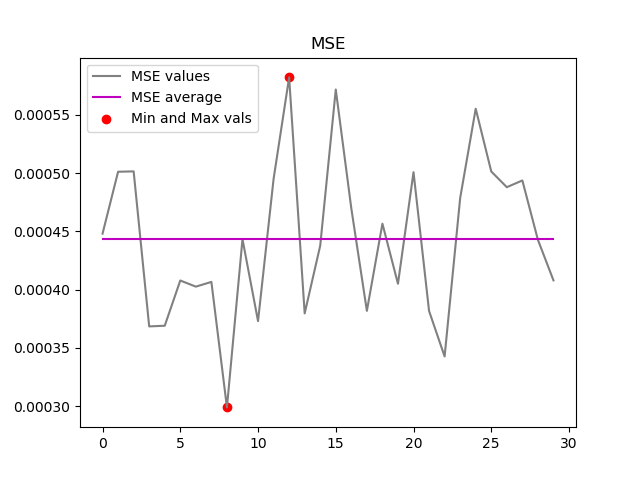

In [42]:
plot_mse(mse_list_100_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.002104399362578988


<IPython.core.display.Javascript object>


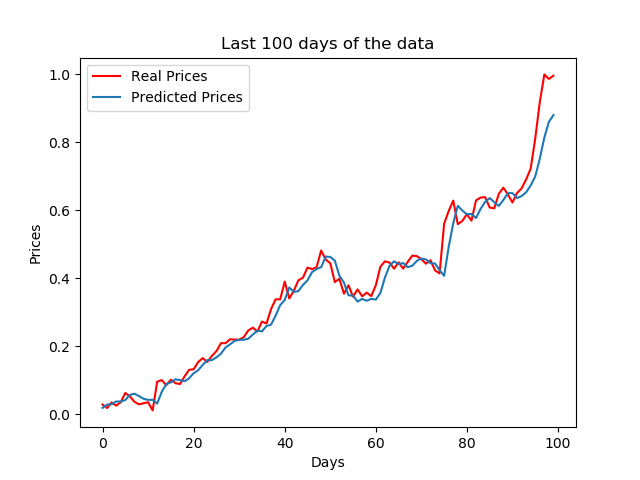

In [43]:
model1_100 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 36us/step
MSE: 0.00038056385330855846


<IPython.core.display.Javascript object>


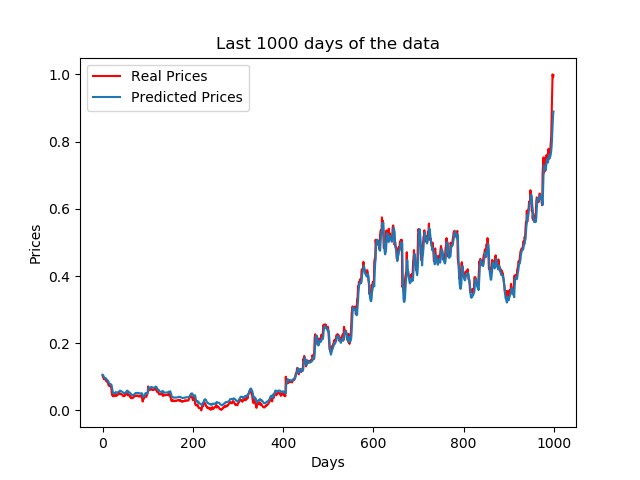

In [44]:
model1_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 40us/step
MSE: 0.00023513326747342945


<IPython.core.display.Javascript object>


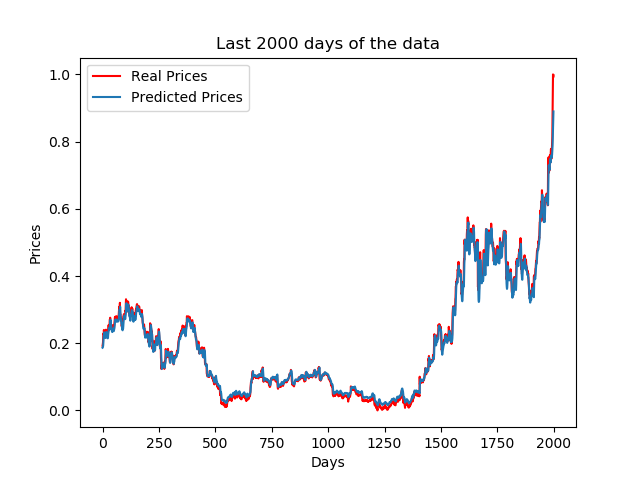

In [45]:
model1_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 2

## Training model 2: 

**(100 input samples extracted, 50% training and 50% testing)**

In [46]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_50[epoch].shape)
    print(y_train_all_100_50[epoch].shape)
    
    # fit the model to the current data
    model_100_50.fit(X_train_all_100_50[epoch],
                     y_train_all_100_50[epoch],
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1092, 50, 1)
(1092, 1)
Epoch 1/70
1092/1092 [==============================] - 1s 732us/step - loss: 0.1436
Epoch 2/70
1092/1092 [==============================] - 0s 51us/step - loss: 0.1362
Epoch 3/70
1092/1092 [==============================] - 0s 47us/step - loss: 0.1285
Epoch 4/70
1092/1092 [==============================] - 0s 51us/step - loss: 0.1212
Epoch 5/70
1092/1092 [==============================] - 0s 56us/step - loss: 0.1141
Epoch 6/70
1092/1092 [==============================] - 0s 50us/step - loss: 0.1074
Epoch 7/70
1092/1092 [==============================] - 0s 55us/step - loss: 0.1010
Epoch 8/70
1092/1092 [==============================] - 0s 56us/step - loss: 0.0949
Epoch 9/70
1092/1092 [==============================] - 0s 59us/step - loss: 0.0892
Epoch 10/70
1092/1092 [==============================] - 0s 48us/step - loss: 0.0838
Epoch 11/70
1092/1092 [==============================] - 0s 56us/step - loss: 0.0787
Epoch 12/70
1092/1092 [==================

1103/1103 [==============================] - 0s 33us/step - loss: 0.0018
Epoch 52/70
1103/1103 [==============================] - 0s 28us/step - loss: 0.0018
Epoch 53/70
1103/1103 [==============================] - 0s 32us/step - loss: 0.0018
Epoch 54/70
1103/1103 [==============================] - 0s 29us/step - loss: 0.0018
Epoch 55/70
1103/1103 [==============================] - 0s 29us/step - loss: 0.0018
Epoch 56/70
1103/1103 [==============================] - 0s 31us/step - loss: 0.0017
Epoch 57/70
1103/1103 [==============================] - 0s 34us/step - loss: 0.0017
Epoch 58/70
1103/1103 [==============================] - 0s 33us/step - loss: 0.0017
Epoch 59/70
1103/1103 [==============================] - 0s 35us/step - loss: 0.0017
Epoch 60/70
1103/1103 [==============================] - 0s 33us/step - loss: 0.0017
Epoch 61/70
1103/1103 [==============================] - 0s 38us/step - loss: 0.0017
Epoch 62/70
1103/1103 [==============================] - 0s 30us/step - loss:

1101/1101 [==============================] - 0s 33us/step - loss: 0.0013
Epoch 32/70
1101/1101 [==============================] - 0s 36us/step - loss: 0.0013
Epoch 33/70
1101/1101 [==============================] - 0s 36us/step - loss: 0.0013
Epoch 34/70
1101/1101 [==============================] - 0s 36us/step - loss: 0.0013
Epoch 35/70
1101/1101 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 36/70
1101/1101 [==============================] - 0s 34us/step - loss: 0.0013
Epoch 37/70
1101/1101 [==============================] - 0s 38us/step - loss: 0.0013
Epoch 38/70
1101/1101 [==============================] - 0s 36us/step - loss: 0.0013
Epoch 39/70
1101/1101 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 40/70
1101/1101 [==============================] - 0s 39us/step - loss: 0.0013
Epoch 41/70
1101/1101 [==============================] - 0s 36us/step - loss: 0.0013
Epoch 42/70
1101/1101 [==============================] - 0s 39us/step - loss:

1110/1110 [==============================] - 0s 17us/step - loss: 0.0015
Epoch 13/70
1110/1110 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 14/70
1110/1110 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 15/70
1110/1110 [==============================] - 0s 17us/step - loss: 0.0015
Epoch 16/70
1110/1110 [==============================] - 0s 19us/step - loss: 0.0015
Epoch 17/70
1110/1110 [==============================] - 0s 21us/step - loss: 0.0014
Epoch 18/70
1110/1110 [==============================] - 0s 18us/step - loss: 0.0014
Epoch 19/70
1110/1110 [==============================] - 0s 19us/step - loss: 0.0014
Epoch 20/70
1110/1110 [==============================] - 0s 18us/step - loss: 0.0014
Epoch 21/70
1110/1110 [==============================] - 0s 19us/step - loss: 0.0014
Epoch 22/70
1110/1110 [==============================] - 0s 21us/step - loss: 0.0014
Epoch 23/70
1110/1110 [==============================] - 0s 19us/step - loss:

1090/1090 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 64/70
1090/1090 [==============================] - 0s 53us/step - loss: 0.0012
Epoch 65/70
1090/1090 [==============================] - 0s 53us/step - loss: 0.0012
Epoch 66/70
1090/1090 [==============================] - 0s 61us/step - loss: 0.0012
Epoch 67/70
1090/1090 [==============================] - 0s 57us/step - loss: 0.0012
Epoch 68/70
1090/1090 [==============================] - 0s 57us/step - loss: 0.0012
Epoch 69/70
1090/1090 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 70/70
1090/1090 [==============================] - 0s 56us/step - loss: 0.0012
epoch=11
(1090, 55, 1)
(1090, 1)
Epoch 1/70
1090/1090 [==============================] - 0s 51us/step - loss: 0.0011
Epoch 2/70
1090/1090 [==============================] - 0s 55us/step - loss: 0.0011
Epoch 3/70
1090/1090 [==============================] - 0s 54us/step - loss: 0.0011
Epoch 4/70
1090/1090 [=========================

Epoch 19/70
1111/1111 [==============================] - 0s 17us/step - loss: 0.0012
Epoch 20/70
1111/1111 [==============================] - 0s 14us/step - loss: 0.0012
Epoch 21/70
1111/1111 [==============================] - 0s 18us/step - loss: 0.0012
Epoch 22/70
1111/1111 [==============================] - 0s 16us/step - loss: 0.0012
Epoch 23/70
1111/1111 [==============================] - 0s 16us/step - loss: 0.0012
Epoch 24/70
1111/1111 [==============================] - 0s 17us/step - loss: 0.0012
Epoch 25/70
1111/1111 [==============================] - 0s 17us/step - loss: 0.0012
Epoch 26/70
1111/1111 [==============================] - 0s 18us/step - loss: 0.0012
Epoch 27/70
1111/1111 [==============================] - 0s 16us/step - loss: 0.0012
Epoch 28/70
1111/1111 [==============================] - 0s 17us/step - loss: 0.0012
Epoch 29/70
1111/1111 [==============================] - 0s 15us/step - loss: 0.0012
Epoch 30/70
1111/1111 [==============================] - 0s 16us/

Epoch 45/70
1072/1072 [==============================] - 0s 97us/step - loss: 0.0011
Epoch 46/70
1072/1072 [==============================] - 0s 116us/step - loss: 0.0011
Epoch 47/70
1072/1072 [==============================] - 0s 83us/step - loss: 0.0011
Epoch 48/70
1072/1072 [==============================] - 0s 89us/step - loss: 0.0011
Epoch 49/70
1072/1072 [==============================] - 0s 95us/step - loss: 0.0011
Epoch 50/70
1072/1072 [==============================] - 0s 99us/step - loss: 0.0011
Epoch 51/70
1072/1072 [==============================] - 0s 92us/step - loss: 0.0011
Epoch 52/70
1072/1072 [==============================] - 0s 84us/step - loss: 0.0011
Epoch 53/70
1072/1072 [==============================] - 0s 96us/step - loss: 0.0011
Epoch 54/70
1072/1072 [==============================] - 0s 95us/step - loss: 0.0011
Epoch 55/70
1072/1072 [==============================] - 0s 89us/step - loss: 0.0011
Epoch 56/70
1072/1072 [==============================] - 0s 84us

epoch=15
(1105, 24, 1)
(1105, 1)
Epoch 1/70
1105/1105 [==============================] - 0s 25us/step - loss: 9.9446e-04
Epoch 2/70
1105/1105 [==============================] - 0s 24us/step - loss: 9.8204e-04
Epoch 3/70
1105/1105 [==============================] - 0s 25us/step - loss: 9.6731e-04
Epoch 4/70
1105/1105 [==============================] - 0s 25us/step - loss: 9.5803e-04
Epoch 5/70
1105/1105 [==============================] - 0s 27us/step - loss: 9.5628e-04
Epoch 6/70
1105/1105 [==============================] - 0s 26us/step - loss: 9.5944e-04
Epoch 7/70
1105/1105 [==============================] - 0s 27us/step - loss: 9.5912e-04
Epoch 8/70
1105/1105 [==============================] - 0s 28us/step - loss: 9.5674e-04
Epoch 9/70
1105/1105 [==============================] - 0s 25us/step - loss: 9.5439e-04
Epoch 10/70
1105/1105 [==============================] - 0s 26us/step - loss: 9.5299e-04
Epoch 11/70
1105/1105 [==============================] - 0s 27us/step - loss: 9.5147e-

1077/1077 [==============================] - 0s 82us/step - loss: 9.2326e-04
Epoch 46/70
1077/1077 [==============================] - ETA: 0s - loss: 9.1518e-0 - 0s 77us/step - loss: 9.2599e-04
Epoch 47/70
1077/1077 [==============================] - 0s 80us/step - loss: 9.2681e-04
Epoch 48/70
1077/1077 [==============================] - 0s 81us/step - loss: 9.2543e-04
Epoch 49/70
1077/1077 [==============================] - 0s 80us/step - loss: 9.1874e-04
Epoch 50/70
1077/1077 [==============================] - 0s 80us/step - loss: 9.1279e-04
Epoch 51/70
1077/1077 [==============================] - 0s 76us/step - loss: 9.1337e-04
Epoch 52/70
1077/1077 [==============================] - 0s 86us/step - loss: 9.1578e-04
Epoch 53/70
1077/1077 [==============================] - 0s 78us/step - loss: 9.1724e-04
Epoch 54/70
1077/1077 [==============================] - 0s 73us/step - loss: 9.1795e-04
Epoch 55/70
1077/1077 [==============================] - 0s 82us/step - loss: 9.1854e-04
Epoch

1107/1107 [==============================] - 0s 21us/step - loss: 8.3056e-04
Epoch 18/70
1107/1107 [==============================] - 0s 22us/step - loss: 8.2975e-04
Epoch 19/70
1107/1107 [==============================] - 0s 22us/step - loss: 8.2925e-04
Epoch 20/70
1107/1107 [==============================] - 0s 25us/step - loss: 8.2873e-04
Epoch 21/70
1107/1107 [==============================] - 0s 26us/step - loss: 8.2945e-04
Epoch 22/70
1107/1107 [==============================] - 0s 23us/step - loss: 8.2926e-04
Epoch 23/70
1107/1107 [==============================] - 0s 23us/step - loss: 8.2873e-04
Epoch 24/70
1107/1107 [==============================] - 0s 23us/step - loss: 8.2844e-04
Epoch 25/70
1107/1107 [==============================] - 0s 22us/step - loss: 8.2750e-04
Epoch 26/70
1107/1107 [==============================] - 0s 21us/step - loss: 8.2677e-04
Epoch 27/70
1107/1107 [==============================] - 0s 21us/step - loss: 8.2658e-04
Epoch 28/70
1107/1107 [==========

1084/1084 [==============================] - 0s 68us/step - loss: 7.8166e-04
Epoch 60/70
1084/1084 [==============================] - 0s 65us/step - loss: 7.8380e-04
Epoch 61/70
1084/1084 [==============================] - 0s 63us/step - loss: 7.8882e-04
Epoch 62/70
1084/1084 [==============================] - 0s 65us/step - loss: 7.9120e-04
Epoch 63/70
1084/1084 [==============================] - 0s 64us/step - loss: 7.8962e-04
Epoch 64/70
1084/1084 [==============================] - 0s 69us/step - loss: 7.8490e-04
Epoch 65/70
1084/1084 [==============================] - 0s 71us/step - loss: 7.8151e-04
Epoch 66/70
1084/1084 [==============================] - 0s 69us/step - loss: 7.8006e-04
Epoch 67/70
1084/1084 [==============================] - 0s 65us/step - loss: 7.8026e-04
Epoch 68/70
1084/1084 [==============================] - 0s 60us/step - loss: 7.8121e-04
Epoch 69/70
1084/1084 [==============================] - 0s 68us/step - loss: 7.8011e-04
Epoch 70/70
1084/1084 [==========

1072/1072 [==============================] - 0s 82us/step - loss: 7.7816e-04
Epoch 32/70
1072/1072 [==============================] - 0s 83us/step - loss: 7.6931e-04
Epoch 33/70
1072/1072 [==============================] - 0s 87us/step - loss: 7.6511e-04
Epoch 34/70
1072/1072 [==============================] - 0s 104us/step - loss: 7.6694e-04
Epoch 35/70
1072/1072 [==============================] - 0s 94us/step - loss: 7.7021e-04
Epoch 36/70
1072/1072 [==============================] - 0s 90us/step - loss: 7.7218e-04
Epoch 37/70
1072/1072 [==============================] - 0s 89us/step - loss: 7.6893e-04
Epoch 38/70
1072/1072 [==============================] - 0s 85us/step - loss: 7.6423e-04
Epoch 39/70
1072/1072 [==============================] - 0s 94us/step - loss: 7.6392e-04
Epoch 40/70
1072/1072 [==============================] - 0s 87us/step - loss: 7.6862e-04
Epoch 41/70
1072/1072 [==============================] - ETA: 0s - loss: 7.6954e-0 - 0s 86us/step - loss: 7.7053e-04
Epoc

1095/1095 [==============================] - 0s 49us/step - loss: 7.4846e-04
Epoch 4/70
1095/1095 [==============================] - 0s 48us/step - loss: 7.4405e-04
Epoch 5/70
1095/1095 [==============================] - 0s 43us/step - loss: 7.4019e-04
Epoch 6/70
1095/1095 [==============================] - 0s 46us/step - loss: 7.4121e-04
Epoch 7/70
1095/1095 [==============================] - 0s 45us/step - loss: 7.4421e-04
Epoch 8/70
1095/1095 [==============================] - 0s 46us/step - loss: 7.4426e-04
Epoch 9/70
1095/1095 [==============================] - 0s 46us/step - loss: 7.4148e-04
Epoch 10/70
1095/1095 [==============================] - 0s 47us/step - loss: 7.3848e-04
Epoch 11/70
1095/1095 [==============================] - 0s 42us/step - loss: 7.3694e-04
Epoch 12/70
1095/1095 [==============================] - 0s 44us/step - loss: 7.3639e-04
Epoch 13/70
1095/1095 [==============================] - 0s 42us/step - loss: 7.3573e-04
Epoch 14/70
1095/1095 [================

Epoch 25/70
1093/1093 [==============================] - 0s 46us/step - loss: 6.7356e-04
Epoch 26/70
1093/1093 [==============================] - 0s 47us/step - loss: 6.7624e-04
Epoch 27/70
1093/1093 [==============================] - 0s 61us/step - loss: 6.7282e-04
Epoch 28/70
1093/1093 [==============================] - 0s 47us/step - loss: 6.6732e-04
Epoch 29/70
1093/1093 [==============================] - 0s 52us/step - loss: 6.6294e-04
Epoch 30/70
1093/1093 [==============================] - 0s 56us/step - loss: 6.6493e-04
Epoch 31/70
1093/1093 [==============================] - 0s 56us/step - loss: 6.6935e-04
Epoch 32/70
1093/1093 [==============================] - 0s 51us/step - loss: 6.7316e-04
Epoch 33/70
1093/1093 [==============================] - 0s 50us/step - loss: 6.7377e-04
Epoch 34/70
1093/1093 [==============================] - 0s 55us/step - loss: 6.6938e-04
Epoch 35/70
1093/1093 [==============================] - 0s 55us/step - loss: 6.6405e-04
Epoch 36/70
1093/1093

## Testing model 2:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_50, X_test_all_100_50, y_test_all_100_50)

In [48]:
mse_list_100_50 = mse_list(model_100_50, X_test_all_100_50, y_test_all_100_50, lengths)

Max mse: 0.001642854855791163 (related window: 12)
Min mse: 0.0006135749237951374 (related window: 18)
Average mse: 0.0007256093746627519


<IPython.core.display.Javascript object>


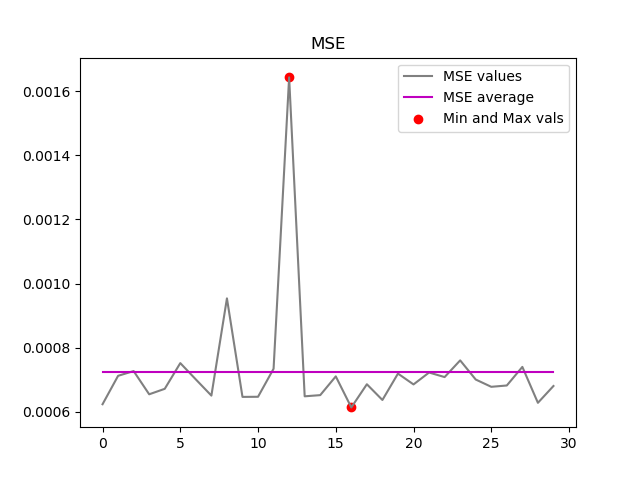

In [49]:
plot_mse(mse_list_100_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.0031483052205294373


<IPython.core.display.Javascript object>


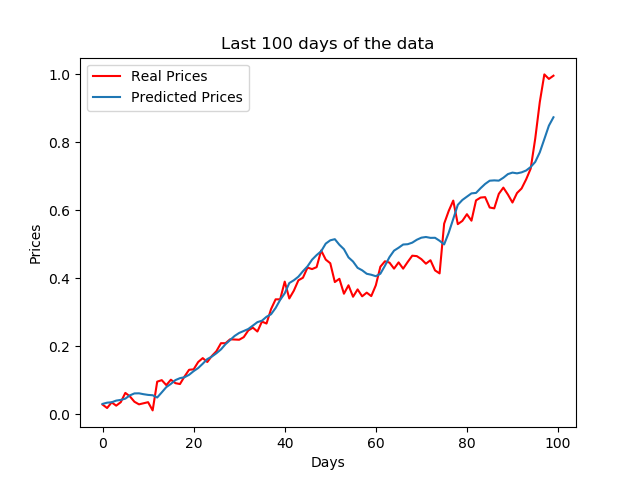

In [50]:
model2_100 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 40us/step
MSE: 0.002291300022043288


<IPython.core.display.Javascript object>


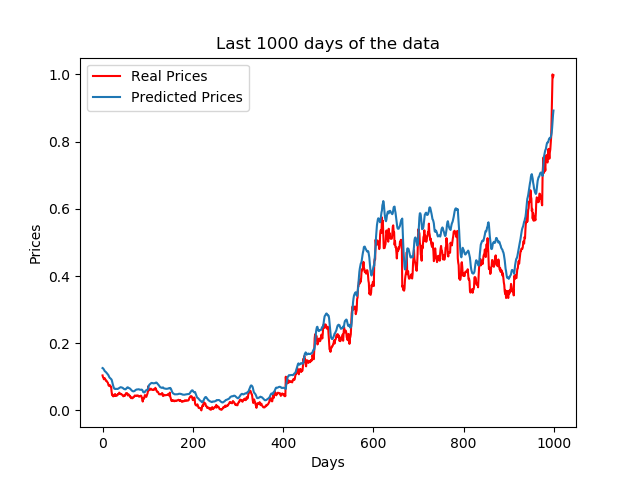

In [51]:
model2_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 40us/step
MSE: 0.0015863469592295586


<IPython.core.display.Javascript object>


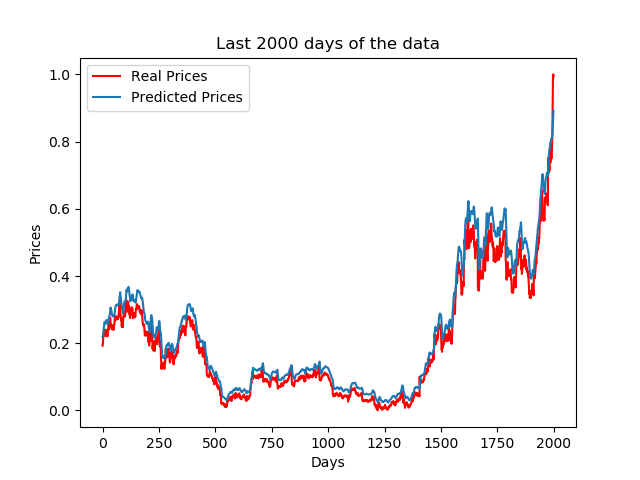

In [52]:
model2_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Model 3

## Training model 3:

**(1000 input samples extracted, 70% training and 30% testing)**

In [53]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_70[epoch].shape)
    print(y_train_all_1000_70[epoch].shape)
    
    # fit the model to the current data
    model_1000_70.fit(X_train_all_1000_70[epoch],
                      y_train_all_1000_70[epoch],
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)
    
    
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(899, 50, 1)
(899, 1)
Epoch 1/70
899/899 [==============================] - 1s 898us/step - loss: 0.1103
Epoch 2/70
899/899 [==============================] - 0s 37us/step - loss: 0.1074
Epoch 3/70
899/899 [==============================] - 0s 30us/step - loss: 0.1046
Epoch 4/70
899/899 [==============================] - 0s 39us/step - loss: 0.1018
Epoch 5/70
899/899 [==============================] - 0s 32us/step - loss: 0.0991
Epoch 6/70
899/899 [==============================] - 0s 28us/step - loss: 0.0964
Epoch 7/70
899/899 [==============================] - 0s 29us/step - loss: 0.0937
Epoch 8/70
899/899 [==============================] - 0s 32us/step - loss: 0.0911
Epoch 9/70
899/899 [==============================] - 0s 40us/step - loss: 0.0885
Epoch 10/70
899/899 [==============================] - 0s 36us/step - loss: 0.0860
Epoch 11/70
899/899 [==============================] - 0s 31us/step - loss: 0.0835
Epoch 12/70
899/899 [==============================] - 0s 37us/st

Epoch 30/70
909/909 [==============================] - 0s 25us/step - loss: 0.0115
Epoch 31/70
909/909 [==============================] - 0s 23us/step - loss: 0.0114
Epoch 32/70
909/909 [==============================] - 0s 22us/step - loss: 0.0113
Epoch 33/70
909/909 [==============================] - 0s 24us/step - loss: 0.0113
Epoch 34/70
909/909 [==============================] - 0s 25us/step - loss: 0.0112
Epoch 35/70
909/909 [==============================] - 0s 25us/step - loss: 0.0111
Epoch 36/70
909/909 [==============================] - 0s 24us/step - loss: 0.0110
Epoch 37/70
909/909 [==============================] - 0s 26us/step - loss: 0.0110
Epoch 38/70
909/909 [==============================] - 0s 32us/step - loss: 0.0109
Epoch 39/70
909/909 [==============================] - 0s 26us/step - loss: 0.0108
Epoch 40/70
909/909 [==============================] - 0s 23us/step - loss: 0.0107
Epoch 41/70
909/909 [==============================] - 0s 25us/step - loss: 0.0107
Epoc

Epoch 59/70
914/914 [==============================] - 0s 17us/step - loss: 0.0055
Epoch 60/70
914/914 [==============================] - 0s 19us/step - loss: 0.0054
Epoch 61/70
914/914 [==============================] - 0s 21us/step - loss: 0.0054
Epoch 62/70
914/914 [==============================] - 0s 19us/step - loss: 0.0054
Epoch 63/70
914/914 [==============================] - 0s 21us/step - loss: 0.0053
Epoch 64/70
914/914 [==============================] - 0s 24us/step - loss: 0.0053
Epoch 65/70
914/914 [==============================] - 0s 21us/step - loss: 0.0052
Epoch 66/70
914/914 [==============================] - 0s 17us/step - loss: 0.0052
Epoch 67/70
914/914 [==============================] - 0s 17us/step - loss: 0.0052
Epoch 68/70
914/914 [==============================] - 0s 21us/step - loss: 0.0051
Epoch 69/70
914/914 [==============================] - 0s 19us/step - loss: 0.0051
Epoch 70/70
914/914 [==============================] - 0s 21us/step - loss: 0.0050
epoc

Epoch 18/70
864/864 [==============================] - 0s 74us/step - loss: 0.0032
Epoch 19/70
864/864 [==============================] - 0s 87us/step - loss: 0.0031
Epoch 20/70
864/864 [==============================] - 0s 69us/step - loss: 0.0031
Epoch 21/70
864/864 [==============================] - 0s 80us/step - loss: 0.0031
Epoch 22/70
864/864 [==============================] - 0s 72us/step - loss: 0.0031
Epoch 23/70
864/864 [==============================] - 0s 74us/step - loss: 0.0031
Epoch 24/70
864/864 [==============================] - 0s 73us/step - loss: 0.0031
Epoch 25/70
864/864 [==============================] - 0s 74us/step - loss: 0.0031
Epoch 26/70
864/864 [==============================] - 0s 94us/step - loss: 0.0031
Epoch 27/70
864/864 [==============================] - 0s 88us/step - loss: 0.0031
Epoch 28/70
864/864 [==============================] - 0s 70us/step - loss: 0.0031
Epoch 29/70
864/864 [==============================] - 0s 70us/step - loss: 0.0030
Epoc

Epoch 47/70
911/911 [==============================] - 0s 23us/step - loss: 0.0027
Epoch 48/70
911/911 [==============================] - 0s 23us/step - loss: 0.0027
Epoch 49/70
911/911 [==============================] - 0s 25us/step - loss: 0.0027
Epoch 50/70
911/911 [==============================] - 0s 24us/step - loss: 0.0027
Epoch 51/70
911/911 [==============================] - 0s 26us/step - loss: 0.0027
Epoch 52/70
911/911 [==============================] - 0s 27us/step - loss: 0.0027
Epoch 53/70
911/911 [==============================] - 0s 24us/step - loss: 0.0027
Epoch 54/70
911/911 [==============================] - 0s 25us/step - loss: 0.0027
Epoch 55/70
911/911 [==============================] - 0s 22us/step - loss: 0.0027
Epoch 56/70
911/911 [==============================] - 0s 27us/step - loss: 0.0027
Epoch 57/70
911/911 [==============================] - 0s 27us/step - loss: 0.0027
Epoch 58/70
911/911 [==============================] - 0s 30us/step - loss: 0.0027
Epoc

Epoch 6/70
903/903 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 7/70
903/903 [==============================] - 0s 38us/step - loss: 0.0025
Epoch 8/70
903/903 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 9/70
903/903 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 10/70
903/903 [==============================] - 0s 32us/step - loss: 0.0025
Epoch 11/70
903/903 [==============================] - 0s 31us/step - loss: 0.0025
Epoch 12/70
903/903 [==============================] - 0s 39us/step - loss: 0.0025
Epoch 13/70
903/903 [==============================] - 0s 28us/step - loss: 0.0025
Epoch 14/70
903/903 [==============================] - 0s 28us/step - loss: 0.0025
Epoch 15/70
903/903 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 16/70
903/903 [==============================] - 0s 30us/step - loss: 0.0025
Epoch 17/70
903/903 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 18

Epoch 35/70
924/924 [==============================] - 0s 10us/step - loss: 0.0022
Epoch 36/70
924/924 [==============================] - 0s 11us/step - loss: 0.0022
Epoch 37/70
924/924 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 38/70
924/924 [==============================] - 0s 11us/step - loss: 0.0022
Epoch 39/70
924/924 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 40/70
924/924 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 41/70
924/924 [==============================] - 0s 16us/step - loss: 0.0022
Epoch 42/70
924/924 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 43/70
924/924 [==============================] - 0s 11us/step - loss: 0.0022
Epoch 44/70
924/924 [==============================] - 0s 12us/step - loss: 0.0022
Epoch 45/70
924/924 [==============================] - 0s 11us/step - loss: 0.0022
Epoch 46/70
924/924 [==============================] - 0s 13us/step - loss: 0.0022
Epoc

Epoch 64/70
868/868 [==============================] - 0s 71us/step - loss: 0.0021
Epoch 65/70
868/868 [==============================] - 0s 59us/step - loss: 0.0021
Epoch 66/70
868/868 [==============================] - 0s 60us/step - loss: 0.0021
Epoch 67/70
868/868 [==============================] - 0s 75us/step - loss: 0.0021
Epoch 68/70
868/868 [==============================] - 0s 65us/step - loss: 0.0021
Epoch 69/70
868/868 [==============================] - 0s 83us/step - loss: 0.0021
Epoch 70/70
868/868 [==============================] - 0s 88us/step - loss: 0.0021
epoch=10
(896, 55, 1)
(896, 1)
Epoch 1/70
896/896 [==============================] - 0s 57us/step - loss: 0.0022
Epoch 2/70
896/896 [==============================] - 0s 43us/step - loss: 0.0022
Epoch 3/70
896/896 [==============================] - 0s 37us/step - loss: 0.0022
Epoch 4/70
896/896 [==============================] - 0s 39us/step - loss: 0.0022
Epoch 5/70
896/896 [==============================] - 0s 50u

Epoch 23/70
896/896 [==============================] - 0s 36us/step - loss: 0.0021
Epoch 24/70
896/896 [==============================] - 0s 38us/step - loss: 0.0021
Epoch 25/70
896/896 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 26/70
896/896 [==============================] - 0s 40us/step - loss: 0.0021
Epoch 27/70
896/896 [==============================] - 0s 36us/step - loss: 0.0021
Epoch 28/70
896/896 [==============================] - 0s 46us/step - loss: 0.0021
Epoch 29/70
896/896 [==============================] - 0s 60us/step - loss: 0.0021
Epoch 30/70
896/896 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 31/70
896/896 [==============================] - 0s 53us/step - loss: 0.0021
Epoch 32/70
896/896 [==============================] - 0s 49us/step - loss: 0.0020
Epoch 33/70
896/896 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 34/70
896/896 [==============================] - 0s 48us/step - loss: 0.0020
Epoc

Epoch 52/70
926/926 [==============================] - 0s 12us/step - loss: 0.0020
Epoch 53/70
926/926 [==============================] - 0s 12us/step - loss: 0.0020
Epoch 54/70
926/926 [==============================] - 0s 17us/step - loss: 0.0020
Epoch 55/70
926/926 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 56/70
926/926 [==============================] - 0s 11us/step - loss: 0.0020
Epoch 57/70
926/926 [==============================] - 0s 12us/step - loss: 0.0020
Epoch 58/70
926/926 [==============================] - 0s 14us/step - loss: 0.0020
Epoch 59/70
926/926 [==============================] - 0s 14us/step - loss: 0.0020
Epoch 60/70
926/926 [==============================] - 0s 15us/step - loss: 0.0020
Epoch 61/70
926/926 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 62/70
926/926 [==============================] - 0s 15us/step - loss: 0.0020
Epoch 63/70
926/926 [==============================] - 0s 16us/step - loss: 0.0020
Epoc

Epoch 11/70
870/870 [==============================] - 0s 63us/step - loss: 0.0018
Epoch 12/70
870/870 [==============================] - 0s 64us/step - loss: 0.0018
Epoch 13/70
870/870 [==============================] - 0s 63us/step - loss: 0.0018
Epoch 14/70
870/870 [==============================] - 0s 79us/step - loss: 0.0018
Epoch 15/70
870/870 [==============================] - 0s 65us/step - loss: 0.0018
Epoch 16/70
870/870 [==============================] - 0s 66us/step - loss: 0.0018
Epoch 17/70
870/870 [==============================] - 0s 60us/step - loss: 0.0018
Epoch 18/70
870/870 [==============================] - 0s 76us/step - loss: 0.0018
Epoch 19/70
870/870 [==============================] - 0s 62us/step - loss: 0.0018
Epoch 20/70
870/870 [==============================] - 0s 71us/step - loss: 0.0018
Epoch 21/70
870/870 [==============================] - 0s 71us/step - loss: 0.0018
Epoch 22/70
870/870 [==============================] - 0s 72us/step - loss: 0.0018
Epoc

Epoch 40/70
917/917 [==============================] - 0s 22us/step - loss: 0.0017
Epoch 41/70
917/917 [==============================] - 0s 17us/step - loss: 0.0017
Epoch 42/70
917/917 [==============================] - 0s 17us/step - loss: 0.0017
Epoch 43/70
917/917 [==============================] - 0s 15us/step - loss: 0.0017
Epoch 44/70
917/917 [==============================] - 0s 17us/step - loss: 0.0017
Epoch 45/70
917/917 [==============================] - 0s 16us/step - loss: 0.0017
Epoch 46/70
917/917 [==============================] - 0s 15us/step - loss: 0.0017
Epoch 47/70
917/917 [==============================] - 0s 21us/step - loss: 0.0017
Epoch 48/70
917/917 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 49/70
917/917 [==============================] - 0s 16us/step - loss: 0.0017
Epoch 50/70
917/917 [==============================] - 0s 22us/step - loss: 0.0017
Epoch 51/70
917/917 [==============================] - 0s 17us/step - loss: 0.0017
Epoc

Epoch 69/70
921/921 [==============================] - 0s 12us/step - loss: 0.0017
Epoch 70/70
921/921 [==============================] - 0s 15us/step - loss: 0.0017
epoch=17
(878, 80, 1)
(878, 1)
Epoch 1/70
878/878 [==============================] - 0s 49us/step - loss: 0.0017
Epoch 2/70
878/878 [==============================] - 0s 64us/step - loss: 0.0017
Epoch 3/70
878/878 [==============================] - 0s 65us/step - loss: 0.0017
Epoch 4/70
878/878 [==============================] - 0s 67us/step - loss: 0.0017
Epoch 5/70
878/878 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 6/70
878/878 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 7/70
878/878 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 8/70
878/878 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 9/70
878/878 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 10/70
878/878 [==============================] - 0s 58us/st

Epoch 28/70
883/883 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 29/70
883/883 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 30/70
883/883 [==============================] - 0s 44us/step - loss: 0.0016
Epoch 31/70
883/883 [==============================] - 0s 61us/step - loss: 0.0016
Epoch 32/70
883/883 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 33/70
883/883 [==============================] - 0s 44us/step - loss: 0.0016
Epoch 34/70
883/883 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 35/70
883/883 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 36/70
883/883 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 37/70
883/883 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 38/70
883/883 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 39/70
883/883 [==============================] - 0s 58us/step - loss: 0.0016
Epoc

Epoch 57/70
917/917 [==============================] - 0s 15us/step - loss: 0.0016
Epoch 58/70
917/917 [==============================] - 0s 18us/step - loss: 0.0016
Epoch 59/70
917/917 [==============================] - 0s 16us/step - loss: 0.0016
Epoch 60/70
917/917 [==============================] - 0s 15us/step - loss: 0.0016
Epoch 61/70
917/917 [==============================] - 0s 20us/step - loss: 0.0016
Epoch 62/70
917/917 [==============================] - 0s 21us/step - loss: 0.0016
Epoch 63/70
917/917 [==============================] - 0s 23us/step - loss: 0.0016
Epoch 64/70
917/917 [==============================] - 0s 18us/step - loss: 0.0016
Epoch 65/70
917/917 [==============================] - 0s 18us/step - loss: 0.0016
Epoch 66/70
917/917 [==============================] - 0s 21us/step - loss: 0.0016
Epoch 67/70
917/917 [==============================] - 0s 17us/step - loss: 0.0016
Epoch 68/70
917/917 [==============================] - 0s 17us/step - loss: 0.0016
Epoc

Epoch 16/70
870/870 [==============================] - 0s 68us/step - loss: 0.0015
Epoch 17/70
870/870 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 18/70
870/870 [==============================] - 0s 68us/step - loss: 0.0015
Epoch 19/70
870/870 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 20/70
870/870 [==============================] - 0s 62us/step - loss: 0.0015
Epoch 21/70
870/870 [==============================] - 0s 66us/step - loss: 0.0015
Epoch 22/70
870/870 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 23/70
870/870 [==============================] - 0s 83us/step - loss: 0.0015
Epoch 24/70
870/870 [==============================] - 0s 64us/step - loss: 0.0015
Epoch 25/70
870/870 [==============================] - 0s 69us/step - loss: 0.0015
Epoch 26/70
870/870 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 27/70
870/870 [==============================] - 0s 63us/step - loss: 0.0015
Epoc

Epoch 45/70
888/888 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 46/70
888/888 [==============================] - 0s 46us/step - loss: 0.0015
Epoch 47/70
888/888 [==============================] - 0s 46us/step - loss: 0.0015
Epoch 48/70
888/888 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 49/70
888/888 [==============================] - 0s 47us/step - loss: 0.0015
Epoch 50/70
888/888 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 51/70
888/888 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 52/70
888/888 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 53/70
888/888 [==============================] - 0s 44us/step - loss: 0.0015
Epoch 54/70
888/888 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 55/70
888/888 [==============================] - 0s 43us/step - loss: 0.0015
Epoch 56/70
888/888 [==============================] - 0s 45us/step - loss: 0.0015
Epoc

919/919 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 4/70
919/919 [==============================] - 0s 16us/step - loss: 0.0015
Epoch 5/70
919/919 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 6/70
919/919 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 7/70
919/919 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 8/70
919/919 [==============================] - 0s 17us/step - loss: 0.0015
Epoch 9/70
919/919 [==============================] - 0s 17us/step - loss: 0.0015
Epoch 10/70
919/919 [==============================] - 0s 16us/step - loss: 0.0015
Epoch 11/70
919/919 [==============================] - 0s 14us/step - loss: 0.0015
Epoch 12/70
919/919 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 13/70
919/919 [==============================] - 0s 16us/step - loss: 0.0015
Epoch 14/70
919/919 [==============================] - 0s 16us/step - loss: 0.0015
Epoch 15/70
919/919 [=

Epoch 32/70
871/871 [==============================] - 0s 63us/step - loss: 0.0015
Epoch 33/70
871/871 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 34/70
871/871 [==============================] - 0s 66us/step - loss: 0.0015
Epoch 35/70
871/871 [==============================] - 0s 72us/step - loss: 0.0015
Epoch 36/70
871/871 [==============================] - 0s 64us/step - loss: 0.0015
Epoch 37/70
871/871 [==============================] - 0s 69us/step - loss: 0.0015
Epoch 38/70
871/871 [==============================] - 0s 78us/step - loss: 0.0015
Epoch 39/70
871/871 [==============================] - 0s 69us/step - loss: 0.0015
Epoch 40/70
871/871 [==============================] - 0s 66us/step - loss: 0.0015
Epoch 41/70
871/871 [==============================] - 0s 68us/step - loss: 0.0015
Epoch 42/70
871/871 [==============================] - 0s 82us/step - loss: 0.0015
Epoch 43/70
871/871 [==============================] - 0s 70us/step - loss: 0.0015
Epoc

Epoch 61/70
888/888 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 62/70
888/888 [==============================] - 0s 43us/step - loss: 0.0014
Epoch 63/70
888/888 [==============================] - 0s 47us/step - loss: 0.0014
Epoch 64/70
888/888 [==============================] - 0s 44us/step - loss: 0.0014
Epoch 65/70
888/888 [==============================] - 0s 49us/step - loss: 0.0014
Epoch 66/70
888/888 [==============================] - 0s 42us/step - loss: 0.0014
Epoch 67/70
888/888 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 68/70
888/888 [==============================] - 0s 40us/step - loss: 0.0014
Epoch 69/70
888/888 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 70/70
888/888 [==============================] - 0s 52us/step - loss: 0.0014
epoch=27
(877, 81, 1)
(877, 1)
Epoch 1/70
877/877 [==============================] - 0s 65us/step - loss: 0.0014
Epoch 2/70
877/877 [==============================] - 0s 

Epoch 20/70
903/903 [==============================] - 0s 33us/step - loss: 0.0013
Epoch 21/70
903/903 [==============================] - 0s 28us/step - loss: 0.0013
Epoch 22/70
903/903 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 23/70
903/903 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 24/70
903/903 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 25/70
903/903 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 26/70
903/903 [==============================] - 0s 29us/step - loss: 0.0013
Epoch 27/70
903/903 [==============================] - 0s 29us/step - loss: 0.0013
Epoch 28/70
903/903 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 29/70
903/903 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 30/70
903/903 [==============================] - 0s 35us/step - loss: 0.0013
Epoch 31/70
903/903 [==============================] - 0s 27us/step - loss: 0.0013
Epoc

Epoch 49/70
900/900 [==============================] - 0s 34us/step - loss: 0.0012
Epoch 50/70
900/900 [==============================] - 0s 33us/step - loss: 0.0012
Epoch 51/70
900/900 [==============================] - 0s 35us/step - loss: 0.0012
Epoch 52/70
900/900 [==============================] - 0s 30us/step - loss: 0.0012
Epoch 53/70
900/900 [==============================] - 0s 30us/step - loss: 0.0012
Epoch 54/70
900/900 [==============================] - 0s 32us/step - loss: 0.0012
Epoch 55/70
900/900 [==============================] - 0s 30us/step - loss: 0.0012
Epoch 56/70
900/900 [==============================] - 0s 33us/step - loss: 0.0012
Epoch 57/70
900/900 [==============================] - 0s 30us/step - loss: 0.0012
Epoch 58/70
900/900 [==============================] - 0s 35us/step - loss: 0.0012
Epoch 59/70
900/900 [==============================] - 0s 34us/step - loss: 0.0012
Epoch 60/70
900/900 [==============================] - 0s 30us/step - loss: 0.0012
Epoc

## Testing model 3:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_70, X_test_all_1000_70, y_test_all_1000_70)

In [55]:
mse_list_1000_70 = mse_list(model_1000_70, X_test_all_1000_70, y_test_all_1000_70, lengths)

Max mse: 0.0022425014368476584 (related window: 12)
Min mse: 0.0011427821353914179 (related window: 29)
Average mse: 0.0013787247864828103


<IPython.core.display.Javascript object>


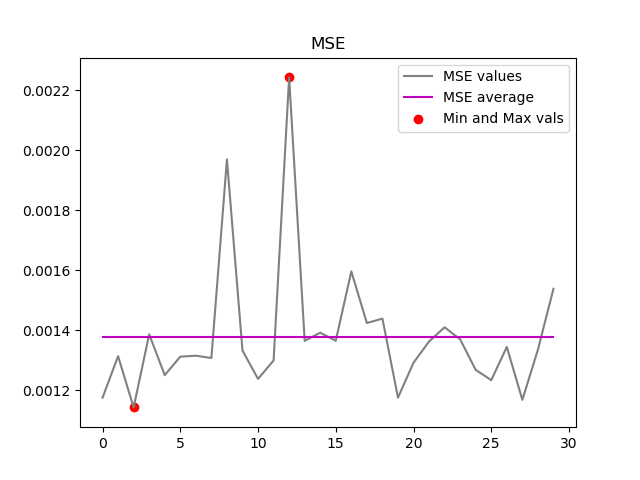

In [56]:
plot_mse(mse_list_1000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 120us/step
MSE: 0.0027786811534315347


<IPython.core.display.Javascript object>


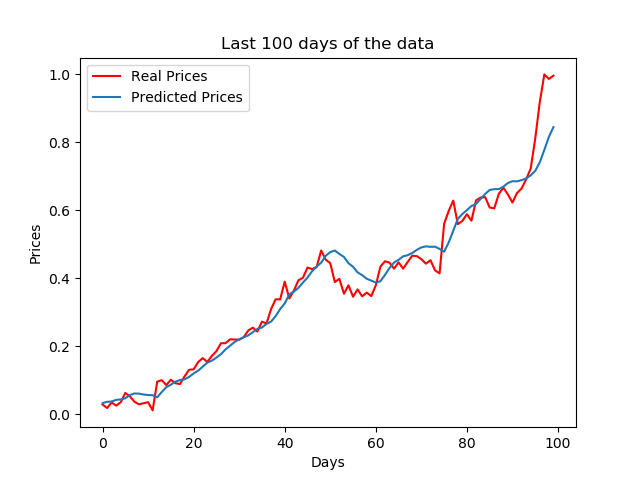

In [57]:
model3_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 42us/step
MSE: 0.0012503628376871348


<IPython.core.display.Javascript object>


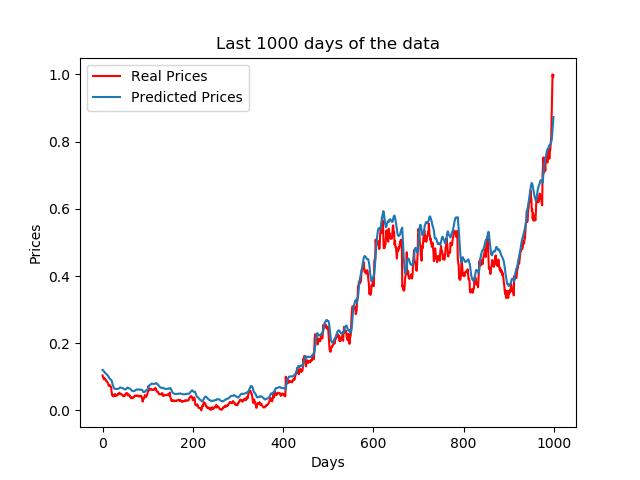

In [58]:
model3_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 36us/step
MSE: 0.000831650499952957


<IPython.core.display.Javascript object>


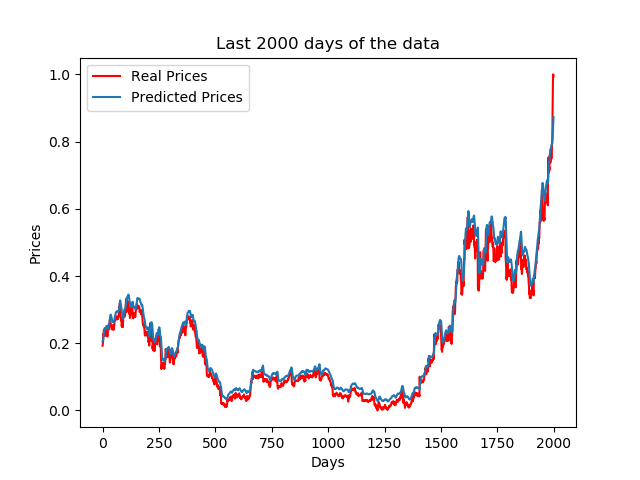

In [59]:
model3_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 4

## Training model 4:

**(1000 input samples extracted, 50% training and 50% testing)**

In [60]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_50[epoch].shape)
    print(y_train_all_1000_50[epoch].shape)
    
    # fit the model to the current data
    model_1000_50.fit(X_train_all_1000_50[epoch],
                      y_train_all_1000_50[epoch],
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(642, 50, 1)
(642, 1)
Epoch 1/70
642/642 [==============================] - 1s 1ms/step - loss: 0.2477
Epoch 2/70
642/642 [==============================] - 0s 39us/step - loss: 0.2443
Epoch 3/70
642/642 [==============================] - 0s 45us/step - loss: 0.2410
Epoch 4/70
642/642 [==============================] - 0s 34us/step - loss: 0.2377
Epoch 5/70
642/642 [==============================] - 0s 39us/step - loss: 0.2344
Epoch 6/70
642/642 [==============================] - 0s 37us/step - loss: 0.2311
Epoch 7/70
642/642 [==============================] - 0s 48us/step - loss: 0.2279
Epoch 8/70
642/642 [==============================] - 0s 39us/step - loss: 0.2247
Epoch 9/70
642/642 [==============================] - 0s 37us/step - loss: 0.2216
Epoch 10/70
642/642 [==============================] - 0s 43us/step - loss: 0.2184
Epoch 11/70
642/642 [==============================] - 0s 43us/step - loss: 0.2153
Epoch 12/70
642/642 [==============================] - 0s 36us/step

Epoch 30/70
649/649 [==============================] - 0s 31us/step - loss: 0.0344
Epoch 31/70
649/649 [==============================] - 0s 31us/step - loss: 0.0336
Epoch 32/70
649/649 [==============================] - 0s 34us/step - loss: 0.0327
Epoch 33/70
649/649 [==============================] - 0s 34us/step - loss: 0.0319
Epoch 34/70
649/649 [==============================] - 0s 28us/step - loss: 0.0311
Epoch 35/70
649/649 [==============================] - 0s 31us/step - loss: 0.0303
Epoch 36/70
649/649 [==============================] - 0s 29us/step - loss: 0.0295
Epoch 37/70
649/649 [==============================] - 0s 35us/step - loss: 0.0288
Epoch 38/70
649/649 [==============================] - 0s 41us/step - loss: 0.0281
Epoch 39/70
649/649 [==============================] - 0s 32us/step - loss: 0.0274
Epoch 40/70
649/649 [==============================] - 0s 41us/step - loss: 0.0267
Epoch 41/70
649/649 [==============================] - 0s 31us/step - loss: 0.0260
Epoc

Epoch 59/70
653/653 [==============================] - 0s 26us/step - loss: 0.0098
Epoch 60/70
653/653 [==============================] - 0s 21us/step - loss: 0.0097
Epoch 61/70
653/653 [==============================] - 0s 23us/step - loss: 0.0097
Epoch 62/70
653/653 [==============================] - 0s 26us/step - loss: 0.0096
Epoch 63/70
653/653 [==============================] - 0s 24us/step - loss: 0.0095
Epoch 64/70
653/653 [==============================] - 0s 21us/step - loss: 0.0095
Epoch 65/70
653/653 [==============================] - 0s 27us/step - loss: 0.0094
Epoch 66/70
653/653 [==============================] - 0s 23us/step - loss: 0.0093
Epoch 67/70
653/653 [==============================] - 0s 23us/step - loss: 0.0092
Epoch 68/70
653/653 [==============================] - 0s 29us/step - loss: 0.0092
Epoch 69/70
653/653 [==============================] - 0s 26us/step - loss: 0.0091
Epoch 70/70
653/653 [==============================] - 0s 27us/step - loss: 0.0090
epoc

Epoch 18/70
617/617 [==============================] - 0s 97us/step - loss: 0.0046
Epoch 19/70
617/617 [==============================] - 0s 84us/step - loss: 0.0046
Epoch 20/70
617/617 [==============================] - 0s 76us/step - loss: 0.0045
Epoch 21/70
617/617 [==============================] - 0s 76us/step - loss: 0.0045
Epoch 22/70
617/617 [==============================] - 0s 76us/step - loss: 0.0045
Epoch 23/70
617/617 [==============================] - 0s 78us/step - loss: 0.0044
Epoch 24/70
617/617 [==============================] - 0s 91us/step - loss: 0.0044
Epoch 25/70
617/617 [==============================] - 0s 79us/step - loss: 0.0044
Epoch 26/70
617/617 [==============================] - 0s 81us/step - loss: 0.0044
Epoch 27/70
617/617 [==============================] - 0s 78us/step - loss: 0.0043
Epoch 28/70
617/617 [==============================] - 0s 97us/step - loss: 0.0043
Epoch 29/70
617/617 [==============================] - 0s 97us/step - loss: 0.0043
Epoc

Epoch 47/70
651/651 [==============================] - 0s 37us/step - loss: 0.0030
Epoch 48/70
651/651 [==============================] - 0s 31us/step - loss: 0.0030
Epoch 49/70
651/651 [==============================] - 0s 31us/step - loss: 0.0030
Epoch 50/70
651/651 [==============================] - 0s 26us/step - loss: 0.0030
Epoch 51/70
651/651 [==============================] - 0s 34us/step - loss: 0.0029
Epoch 52/70
651/651 [==============================] - 0s 29us/step - loss: 0.0029
Epoch 53/70
651/651 [==============================] - 0s 26us/step - loss: 0.0029
Epoch 54/70
651/651 [==============================] - 0s 29us/step - loss: 0.0029
Epoch 55/70
651/651 [==============================] - 0s 28us/step - loss: 0.0029
Epoch 56/70
651/651 [==============================] - 0s 29us/step - loss: 0.0029
Epoch 57/70
651/651 [==============================] - 0s 25us/step - loss: 0.0029
Epoch 58/70
651/651 [==============================] - 0s 25us/step - loss: 0.0029
Epoc

Epoch 6/70
645/645 [==============================] - 0s 34us/step - loss: 0.0029
Epoch 7/70
645/645 [==============================] - 0s 32us/step - loss: 0.0029
Epoch 8/70
645/645 [==============================] - 0s 46us/step - loss: 0.0029
Epoch 9/70
645/645 [==============================] - 0s 70us/step - loss: 0.0029
Epoch 10/70
645/645 [==============================] - 0s 45us/step - loss: 0.0029
Epoch 11/70
645/645 [==============================] - 0s 62us/step - loss: 0.0029
Epoch 12/70
645/645 [==============================] - 0s 49us/step - loss: 0.0029
Epoch 13/70
645/645 [==============================] - 0s 63us/step - loss: 0.0029
Epoch 14/70
645/645 [==============================] - 0s 53us/step - loss: 0.0029
Epoch 15/70
645/645 [==============================] - 0s 39us/step - loss: 0.0029
Epoch 16/70
645/645 [==============================] - 0s 39us/step - loss: 0.0029
Epoch 17/70
645/645 [==============================] - 0s 34us/step - loss: 0.0029
Epoch 18

Epoch 35/70
660/660 [==============================] - 0s 14us/step - loss: 0.0025
Epoch 36/70
660/660 [==============================] - 0s 20us/step - loss: 0.0025
Epoch 37/70
660/660 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 38/70
660/660 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 39/70
660/660 [==============================] - 0s 17us/step - loss: 0.0025
Epoch 40/70
660/660 [==============================] - 0s 12us/step - loss: 0.0025
Epoch 41/70
660/660 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 42/70
660/660 [==============================] - 0s 14us/step - loss: 0.0025
Epoch 43/70
660/660 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 44/70
660/660 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 45/70
660/660 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 46/70
660/660 [==============================] - 0s 32us/step - loss: 0.0024
Epoc

Epoch 64/70
620/620 [==============================] - 0s 77us/step - loss: 0.0025
Epoch 65/70
620/620 [==============================] - 0s 80us/step - loss: 0.0025
Epoch 66/70
620/620 [==============================] - 0s 74us/step - loss: 0.0025
Epoch 67/70
620/620 [==============================] - 0s 87us/step - loss: 0.0025
Epoch 68/70
620/620 [==============================] - 0s 82us/step - loss: 0.0025
Epoch 69/70
620/620 [==============================] - 0s 84us/step - loss: 0.0025
Epoch 70/70
620/620 [==============================] - 0s 90us/step - loss: 0.0025
epoch=10
(640, 55, 1)
(640, 1)
Epoch 1/70
640/640 [==============================] - 0s 51us/step - loss: 0.0026
Epoch 2/70
640/640 [==============================] - 0s 42us/step - loss: 0.0026
Epoch 3/70
640/640 [==============================] - 0s 47us/step - loss: 0.0026
Epoch 4/70
640/640 [==============================] - 0s 48us/step - loss: 0.0026
Epoch 5/70
640/640 [==============================] - 0s 55u

Epoch 23/70
640/640 [==============================] - 0s 47us/step - loss: 0.0024
Epoch 24/70
640/640 [==============================] - 0s 70us/step - loss: 0.0024
Epoch 25/70
640/640 [==============================] - 0s 55us/step - loss: 0.0024
Epoch 26/70
640/640 [==============================] - 0s 55us/step - loss: 0.0024
Epoch 27/70
640/640 [==============================] - 0s 87us/step - loss: 0.0024
Epoch 28/70
640/640 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 29/70
640/640 [==============================] - 0s 59us/step - loss: 0.0024
Epoch 30/70
640/640 [==============================] - 0s 65us/step - loss: 0.0024
Epoch 31/70
640/640 [==============================] - 0s 61us/step - loss: 0.0024
Epoch 32/70
640/640 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 33/70
640/640 [==============================] - 0s 56us/step - loss: 0.0024
Epoch 34/70
640/640 [==============================] - 0s 37us/step - loss: 0.0024
Epoc

Epoch 52/70
661/661 [==============================] - 0s 14us/step - loss: 0.0020
Epoch 53/70
661/661 [==============================] - 0s 18us/step - loss: 0.0019
Epoch 54/70
661/661 [==============================] - 0s 17us/step - loss: 0.0019
Epoch 55/70
661/661 [==============================] - 0s 21us/step - loss: 0.0019
Epoch 56/70
661/661 [==============================] - 0s 17us/step - loss: 0.0019
Epoch 57/70
661/661 [==============================] - 0s 12us/step - loss: 0.0019
Epoch 58/70
661/661 [==============================] - 0s 14us/step - loss: 0.0019
Epoch 59/70
661/661 [==============================] - 0s 15us/step - loss: 0.0019
Epoch 60/70
661/661 [==============================] - 0s 15us/step - loss: 0.0019
Epoch 61/70
661/661 [==============================] - 0s 15us/step - loss: 0.0019
Epoch 62/70
661/661 [==============================] - 0s 14us/step - loss: 0.0019
Epoch 63/70
661/661 [==============================] - 0s 15us/step - loss: 0.0019
Epoc

Epoch 10/70
621/621 [==============================] - 0s 87us/step - loss: 0.0019
Epoch 11/70
621/621 [==============================] - 0s 122us/step - loss: 0.0019
Epoch 12/70
621/621 [==============================] - 0s 79us/step - loss: 0.0019
Epoch 13/70
621/621 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 14/70
621/621 [==============================] - 0s 108us/step - loss: 0.0019
Epoch 15/70
621/621 [==============================] - 0s 127us/step - loss: 0.0019
Epoch 16/70
621/621 [==============================] - 0s 130us/step - loss: 0.0019
Epoch 17/70
621/621 [==============================] - 0s 111us/step - loss: 0.0019
Epoch 18/70
621/621 [==============================] - 0s 96us/step - loss: 0.0019
Epoch 19/70
621/621 [==============================] - 0s 127us/step - loss: 0.0019
Epoch 20/70
621/621 [==============================] - 0s 100us/step - loss: 0.0019
Epoch 21/70
621/621 [==============================] - 0s 104us/step - loss: 0.0

655/655 [==============================] - 0s 23us/step - loss: 0.0020
Epoch 39/70
655/655 [==============================] - 0s 23us/step - loss: 0.0020
Epoch 40/70
655/655 [==============================] - 0s 26us/step - loss: 0.0020
Epoch 41/70
655/655 [==============================] - 0s 20us/step - loss: 0.0020
Epoch 42/70
655/655 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 43/70
655/655 [==============================] - 0s 24us/step - loss: 0.0020
Epoch 44/70
655/655 [==============================] - 0s 26us/step - loss: 0.0020
Epoch 45/70
655/655 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 46/70
655/655 [==============================] - 0s 20us/step - loss: 0.0020
Epoch 47/70
655/655 [==============================] - 0s 26us/step - loss: 0.0020
Epoch 48/70
655/655 [==============================] - 0s 23us/step - loss: 0.0020
Epoch 49/70
655/655 [==============================] - 0s 29us/step - loss: 0.0020
Epoch 50/70
655/

Epoch 67/70
658/658 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 68/70
658/658 [==============================] - 0s 17us/step - loss: 0.0017
Epoch 69/70
658/658 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 70/70
658/658 [==============================] - 0s 17us/step - loss: 0.0017
epoch=17
(627, 80, 1)
(627, 1)
Epoch 1/70
627/627 [==============================] - 0s 67us/step - loss: 0.0021
Epoch 2/70
627/627 [==============================] - 0s 62us/step - loss: 0.0021
Epoch 3/70
627/627 [==============================] - 0s 64us/step - loss: 0.0021
Epoch 4/70
627/627 [==============================] - 0s 72us/step - loss: 0.0021
Epoch 5/70
627/627 [==============================] - 0s 75us/step - loss: 0.0021
Epoch 6/70
627/627 [==============================] - 0s 80us/step - loss: 0.0020
Epoch 7/70
627/627 [==============================] - 0s 89us/step - loss: 0.0020
Epoch 8/70
627/627 [==============================] - 0s 68us/s

Epoch 26/70
631/631 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 27/70
631/631 [==============================] - 0s 62us/step - loss: 0.0019
Epoch 28/70
631/631 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 29/70
631/631 [==============================] - 0s 57us/step - loss: 0.0019
Epoch 30/70
631/631 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 31/70
631/631 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 32/70
631/631 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 33/70
631/631 [==============================] - 0s 62us/step - loss: 0.0019
Epoch 34/70
631/631 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 35/70
631/631 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 36/70
631/631 [==============================] - 0s 58us/step - loss: 0.0019
Epoch 37/70
631/631 [==============================] - 0s 63us/step - loss: 0.0019
Epoc

Epoch 55/70
655/655 [==============================] - 0s 24us/step - loss: 0.0017
Epoch 56/70
655/655 [==============================] - 0s 23us/step - loss: 0.0017
Epoch 57/70
655/655 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 58/70
655/655 [==============================] - 0s 23us/step - loss: 0.0017
Epoch 59/70
655/655 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 60/70
655/655 [==============================] - 0s 24us/step - loss: 0.0017
Epoch 61/70
655/655 [==============================] - 0s 24us/step - loss: 0.0017
Epoch 62/70
655/655 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 63/70
655/655 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 64/70
655/655 [==============================] - 0s 26us/step - loss: 0.0017
Epoch 65/70
655/655 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 66/70
655/655 [==============================] - 0s 26us/step - loss: 0.0017
Epoc

Epoch 14/70
621/621 [==============================] - 0s 82us/step - loss: 0.0016
Epoch 15/70
621/621 [==============================] - 0s 66us/step - loss: 0.0016
Epoch 16/70
621/621 [==============================] - 0s 74us/step - loss: 0.0016
Epoch 17/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 18/70
621/621 [==============================] - 0s 63us/step - loss: 0.0016
Epoch 19/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 20/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 21/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 22/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 23/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 24/70
621/621 [==============================] - 0s 67us/step - loss: 0.0016
Epoch 25/70
621/621 [==============================] - 0s 64us/step - loss: 0.0016
Epoc

Epoch 43/70
634/634 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 44/70
634/634 [==============================] - 0s 64us/step - loss: 0.0015
Epoch 45/70
634/634 [==============================] - 0s 71us/step - loss: 0.0015
Epoch 46/70
634/634 [==============================] - 0s 68us/step - loss: 0.0015
Epoch 47/70
634/634 [==============================] - 0s 61us/step - loss: 0.0015
Epoch 48/70
634/634 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 49/70
634/634 [==============================] - 0s 64us/step - loss: 0.0015
Epoch 50/70
634/634 [==============================] - 0s 76us/step - loss: 0.0015
Epoch 51/70
634/634 [==============================] - 0s 71us/step - loss: 0.0015
Epoch 52/70
634/634 [==============================] - 0s 74us/step - loss: 0.0015
Epoch 53/70
634/634 [==============================] - 0s 79us/step - loss: 0.0015
Epoch 54/70
634/634 [==============================] - 0s 63us/step - loss: 0.0015
Epoc

656/656 [==============================] - 0s 21us/step - loss: 0.0017
Epoch 2/70
656/656 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 3/70
656/656 [==============================] - 0s 21us/step - loss: 0.0017
Epoch 4/70
656/656 [==============================] - 0s 23us/step - loss: 0.0017
Epoch 5/70
656/656 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 6/70
656/656 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 7/70
656/656 [==============================] - 0s 21us/step - loss: 0.0017
Epoch 8/70
656/656 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 9/70
656/656 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 10/70
656/656 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 11/70
656/656 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 12/70
656/656 [==============================] - 0s 18us/step - loss: 0.0017
Epoch 13/70
656/656 [===

Epoch 30/70
622/622 [==============================] - 0s 67us/step - loss: 0.0014
Epoch 31/70
622/622 [==============================] - 0s 82us/step - loss: 0.0014
Epoch 32/70
622/622 [==============================] - 0s 80us/step - loss: 0.0014
Epoch 33/70
622/622 [==============================] - 0s 72us/step - loss: 0.0014
Epoch 34/70
622/622 [==============================] - 0s 83us/step - loss: 0.0014
Epoch 35/70
622/622 [==============================] - 0s 69us/step - loss: 0.0014
Epoch 36/70
622/622 [==============================] - 0s 87us/step - loss: 0.0014
Epoch 37/70
622/622 [==============================] - 0s 77us/step - loss: 0.0014
Epoch 38/70
622/622 [==============================] - 0s 93us/step - loss: 0.0014
Epoch 39/70
622/622 [==============================] - 0s 83us/step - loss: 0.0014
Epoch 40/70
622/622 [==============================] - 0s 79us/step - loss: 0.0014
Epoch 41/70
622/622 [==============================] - 0s 72us/step - loss: 0.0014
Epoc

Epoch 59/70
634/634 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 60/70
634/634 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 61/70
634/634 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 62/70
634/634 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 63/70
634/634 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 64/70
634/634 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 65/70
634/634 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 66/70
634/634 [==============================] - 0s 68us/step - loss: 0.0016
Epoch 67/70
634/634 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 68/70
634/634 [==============================] - 0s 57us/step - loss: 0.0016
Epoch 69/70
634/634 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 70/70
634/634 [==============================] - 0s 50us/step - loss: 0.0016
epoc

Epoch 18/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 19/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 20/70
645/645 [==============================] - 0s 32us/step - loss: 0.0014
Epoch 21/70
645/645 [==============================] - 0s 29us/step - loss: 0.0014
Epoch 22/70
645/645 [==============================] - 0s 29us/step - loss: 0.0014
Epoch 23/70
645/645 [==============================] - 0s 32us/step - loss: 0.0014
Epoch 24/70
645/645 [==============================] - 0s 32us/step - loss: 0.0014
Epoch 25/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 26/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 27/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 28/70
645/645 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 29/70
645/645 [==============================] - 0s 31us/step - loss: 0.0014
Epoc

Epoch 47/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 48/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 49/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 50/70
643/643 [==============================] - 0s 36us/step - loss: 0.0014
Epoch 51/70
643/643 [==============================] - 0s 37us/step - loss: 0.0014
Epoch 52/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 53/70
643/643 [==============================] - 0s 36us/step - loss: 0.0014
Epoch 54/70
643/643 [==============================] - 0s 36us/step - loss: 0.0014
Epoch 55/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 56/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 57/70
643/643 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 58/70
643/643 [==============================] - 0s 42us/step - loss: 0.0014
Epoc

## Testing model 4:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_50, X_test_all_1000_50, y_test_all_1000_50)

In [62]:
mse_list_1000_50 = mse_list(model_1000_50, X_test_all_1000_50, y_test_all_1000_50, lengths)

Max mse: 0.0016417990635948262 (related window: 12)
Min mse: 0.0012929240812028686 (related window: 22)
Average mse: 0.001459887592647943


<IPython.core.display.Javascript object>


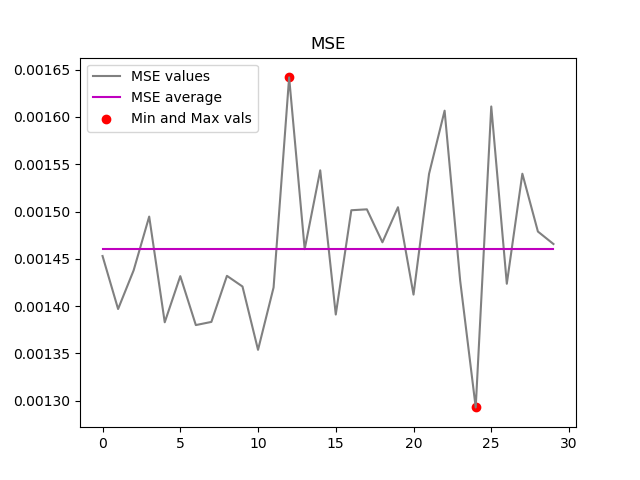

In [63]:
plot_mse(mse_list_1000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 90us/step
MSE: 0.004351783208549022


<IPython.core.display.Javascript object>


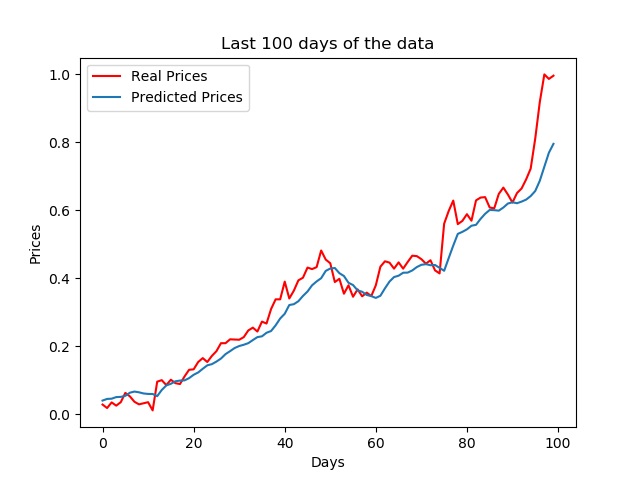

In [64]:
model4_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 52us/step
MSE: 0.0009084181976504624


<IPython.core.display.Javascript object>


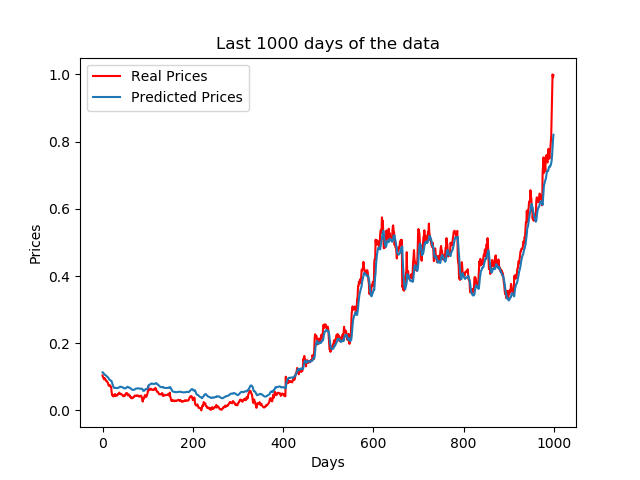

In [65]:
model4_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 37us/step
MSE: 0.0005784748562145979


<IPython.core.display.Javascript object>


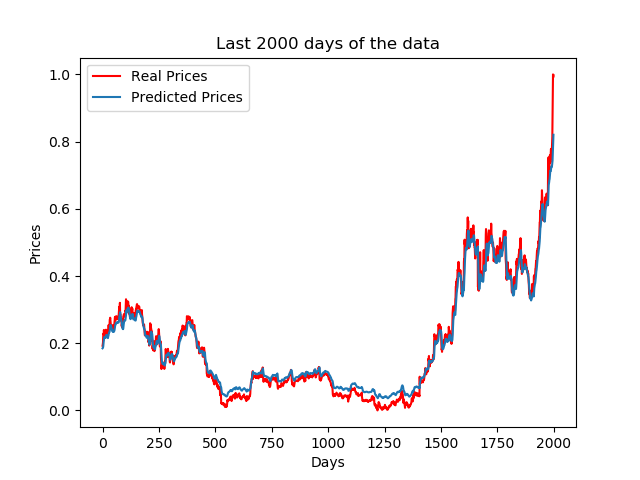

In [66]:
model4_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 5

## Training model 5:

**(2000 input samples extracted, 70% training and 30% testing)**

In [67]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_70[epoch].shape)
    print(y_train_all_2000_70[epoch].shape)
    
    # fit the model to the current data
    model_2000_70.fit(X_train_all_2000_70[epoch],
                      y_train_all_2000_70[epoch],
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(199, 50, 1)
(199, 1)
Epoch 1/70
199/199 [==============================] - 1s 5ms/step - loss: 0.5288
Epoch 2/70
199/199 [==============================] - 0s 125us/step - loss: 0.5198
Epoch 3/70
199/199 [==============================] - 0s 105us/step - loss: 0.5110
Epoch 4/70
199/199 [==============================] - 0s 100us/step - loss: 0.5023
Epoch 5/70
199/199 [==============================] - 0s 125us/step - loss: 0.4937
Epoch 6/70
199/199 [==============================] - 0s 125us/step - loss: 0.4853
Epoch 7/70
199/199 [==============================] - 0s 105us/step - loss: 0.4769
Epoch 8/70
199/199 [==============================] - 0s 100us/step - loss: 0.4687
Epoch 9/70
199/199 [==============================] - 0s 105us/step - loss: 0.4606
Epoch 10/70
199/199 [==============================] - 0s 115us/step - loss: 0.4526
Epoch 11/70
199/199 [==============================] - 0s 110us/step - loss: 0.4448
Epoch 12/70
199/199 [==============================] - 0s

Epoch 29/70
209/209 [==============================] - 0s 81us/step - loss: 0.0740
Epoch 30/70
209/209 [==============================] - 0s 86us/step - loss: 0.0725
Epoch 31/70
209/209 [==============================] - 0s 72us/step - loss: 0.0711
Epoch 32/70
209/209 [==============================] - 0s 76us/step - loss: 0.0697
Epoch 33/70
209/209 [==============================] - 0s 72us/step - loss: 0.0684
Epoch 34/70
209/209 [==============================] - 0s 76us/step - loss: 0.0670
Epoch 35/70
209/209 [==============================] - 0s 72us/step - loss: 0.0657
Epoch 36/70
209/209 [==============================] - 0s 76us/step - loss: 0.0645
Epoch 37/70
209/209 [==============================] - 0s 72us/step - loss: 0.0632
Epoch 38/70
209/209 [==============================] - 0s 76us/step - loss: 0.0620
Epoch 39/70
209/209 [==============================] - 0s 91us/step - loss: 0.0609
Epoch 40/70
209/209 [==============================] - 0s 76us/step - loss: 0.0597
Epoc

Epoch 58/70
214/214 [==============================] - 0s 75us/step - loss: 0.0290
Epoch 59/70
214/214 [==============================] - 0s 70us/step - loss: 0.0289
Epoch 60/70
214/214 [==============================] - 0s 61us/step - loss: 0.0287
Epoch 61/70
214/214 [==============================] - 0s 61us/step - loss: 0.0286
Epoch 62/70
214/214 [==============================] - 0s 61us/step - loss: 0.0285
Epoch 63/70
214/214 [==============================] - 0s 75us/step - loss: 0.0283
Epoch 64/70
214/214 [==============================] - 0s 56us/step - loss: 0.0282
Epoch 65/70
214/214 [==============================] - 0s 65us/step - loss: 0.0281
Epoch 66/70
214/214 [==============================] - 0s 61us/step - loss: 0.0279
Epoch 67/70
214/214 [==============================] - 0s 56us/step - loss: 0.0278
Epoch 68/70
214/214 [==============================] - 0s 61us/step - loss: 0.0276
Epoch 69/70
214/214 [==============================] - 0s 70us/step - loss: 0.0275
Epoc

Epoch 16/70
164/164 [==============================] - 0s 243us/step - loss: 0.0201
Epoch 17/70
164/164 [==============================] - 0s 231us/step - loss: 0.0200
Epoch 18/70
164/164 [==============================] - 0s 243us/step - loss: 0.0200
Epoch 19/70
164/164 [==============================] - 0s 237us/step - loss: 0.0199
Epoch 20/70
164/164 [==============================] - 0s 243us/step - loss: 0.0199
Epoch 21/70
164/164 [==============================] - 0s 262us/step - loss: 0.0198
Epoch 22/70
164/164 [==============================] - 0s 286us/step - loss: 0.0198
Epoch 23/70
164/164 [==============================] - 0s 280us/step - loss: 0.0197
Epoch 24/70
164/164 [==============================] - 0s 274us/step - loss: 0.0197
Epoch 25/70
164/164 [==============================] - 0s 274us/step - loss: 0.0196
Epoch 26/70
164/164 [==============================] - 0s 353us/step - loss: 0.0196
Epoch 27/70
164/164 [==============================] - 0s 225us/step - loss:

Epoch 44/70
211/211 [==============================] - 0s 76us/step - loss: 0.0135
Epoch 45/70
211/211 [==============================] - 0s 85us/step - loss: 0.0135
Epoch 46/70
211/211 [==============================] - 0s 66us/step - loss: 0.0134
Epoch 47/70
211/211 [==============================] - 0s 80us/step - loss: 0.0134
Epoch 48/70
211/211 [==============================] - 0s 71us/step - loss: 0.0133
Epoch 49/70
211/211 [==============================] - 0s 66us/step - loss: 0.0133
Epoch 50/70
211/211 [==============================] - 0s 71us/step - loss: 0.0132
Epoch 51/70
211/211 [==============================] - 0s 80us/step - loss: 0.0132
Epoch 52/70
211/211 [==============================] - 0s 80us/step - loss: 0.0132
Epoch 53/70
211/211 [==============================] - 0s 71us/step - loss: 0.0131
Epoch 54/70
211/211 [==============================] - 0s 71us/step - loss: 0.0131
Epoch 55/70
211/211 [==============================] - 0s 71us/step - loss: 0.0130
Epoc

Epoch 2/70
203/203 [==============================] - 0s 93us/step - loss: 0.0109
Epoch 3/70
203/203 [==============================] - 0s 98us/step - loss: 0.0109
Epoch 4/70
203/203 [==============================] - 0s 108us/step - loss: 0.0109
Epoch 5/70
203/203 [==============================] - 0s 93us/step - loss: 0.0109
Epoch 6/70
203/203 [==============================] - 0s 108us/step - loss: 0.0109
Epoch 7/70
203/203 [==============================] - 0s 93us/step - loss: 0.0108
Epoch 8/70
203/203 [==============================] - 0s 93us/step - loss: 0.0108
Epoch 9/70
203/203 [==============================] - 0s 98us/step - loss: 0.0108
Epoch 10/70
203/203 [==============================] - 0s 118us/step - loss: 0.0108
Epoch 11/70
203/203 [==============================] - 0s 93us/step - loss: 0.0108
Epoch 12/70
203/203 [==============================] - 0s 103us/step - loss: 0.0108
Epoch 13/70
203/203 [==============================] - 0s 113us/step - loss: 0.0107
Epoch 1

Epoch 31/70
224/224 [==============================] - 0s 36us/step - loss: 0.0098
Epoch 32/70
224/224 [==============================] - 0s 31us/step - loss: 0.0098
Epoch 33/70
224/224 [==============================] - 0s 36us/step - loss: 0.0098
Epoch 34/70
224/224 [==============================] - 0s 40us/step - loss: 0.0097
Epoch 35/70
224/224 [==============================] - 0s 31us/step - loss: 0.0097
Epoch 36/70
224/224 [==============================] - 0s 36us/step - loss: 0.0097
Epoch 37/70
224/224 [==============================] - 0s 36us/step - loss: 0.0097
Epoch 38/70
224/224 [==============================] - 0s 31us/step - loss: 0.0096
Epoch 39/70
224/224 [==============================] - 0s 36us/step - loss: 0.0096
Epoch 40/70
224/224 [==============================] - 0s 31us/step - loss: 0.0096
Epoch 41/70
224/224 [==============================] - 0s 40us/step - loss: 0.0096
Epoch 42/70
224/224 [==============================] - 0s 31us/step - loss: 0.0095
Epoc

Epoch 59/70
168/168 [==============================] - 0s 208us/step - loss: 0.0089
Epoch 60/70
168/168 [==============================] - 0s 261us/step - loss: 0.0089
Epoch 61/70
168/168 [==============================] - 0s 202us/step - loss: 0.0088
Epoch 62/70
168/168 [==============================] - 0s 208us/step - loss: 0.0088
Epoch 63/70
168/168 [==============================] - 0s 237us/step - loss: 0.0088
Epoch 64/70
168/168 [==============================] - 0s 249us/step - loss: 0.0088
Epoch 65/70
168/168 [==============================] - 0s 220us/step - loss: 0.0088
Epoch 66/70
168/168 [==============================] - 0s 208us/step - loss: 0.0088
Epoch 67/70
168/168 [==============================] - 0s 220us/step - loss: 0.0087
Epoch 68/70
168/168 [==============================] - 0s 237us/step - loss: 0.0087
Epoch 69/70
168/168 [==============================] - 0s 279us/step - loss: 0.0087
Epoch 70/70
168/168 [==============================] - 0s 232us/step - loss:

196/196 [==============================] - 0s 117us/step - loss: 0.0076
Epoch 17/70
196/196 [==============================] - 0s 137us/step - loss: 0.0076
Epoch 18/70
196/196 [==============================] - 0s 112us/step - loss: 0.0076
Epoch 19/70
196/196 [==============================] - 0s 112us/step - loss: 0.0076
Epoch 20/70
196/196 [==============================] - 0s 137us/step - loss: 0.0076
Epoch 21/70
196/196 [==============================] - 0s 127us/step - loss: 0.0076
Epoch 22/70
196/196 [==============================] - 0s 127us/step - loss: 0.0075
Epoch 23/70
196/196 [==============================] - 0s 148us/step - loss: 0.0075
Epoch 24/70
196/196 [==============================] - 0s 122us/step - loss: 0.0075
Epoch 25/70
196/196 [==============================] - 0s 148us/step - loss: 0.0075
Epoch 26/70
196/196 [==============================] - 0s 122us/step - loss: 0.0075
Epoch 27/70
196/196 [==============================] - 0s 127us/step - loss: 0.0075
Epoc

Epoch 44/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 45/70
226/226 [==============================] - 0s 31us/step - loss: 0.0076
Epoch 46/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 47/70
226/226 [==============================] - 0s 35us/step - loss: 0.0076
Epoch 48/70
226/226 [==============================] - 0s 40us/step - loss: 0.0076
Epoch 49/70
226/226 [==============================] - 0s 31us/step - loss: 0.0076
Epoch 50/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 51/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 52/70
226/226 [==============================] - 0s 31us/step - loss: 0.0076
Epoch 53/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 54/70
226/226 [==============================] - 0s 26us/step - loss: 0.0076
Epoch 55/70
226/226 [==============================] - 0s 31us/step - loss: 0.0076
Epoc

Epoch 2/70
170/170 [==============================] - 0s 199us/step - loss: 0.0077
Epoch 3/70
170/170 [==============================] - 0s 199us/step - loss: 0.0077
Epoch 4/70
170/170 [==============================] - 0s 211us/step - loss: 0.0077
Epoch 5/70
170/170 [==============================] - 0s 182us/step - loss: 0.0077
Epoch 6/70
170/170 [==============================] - 0s 188us/step - loss: 0.0077
Epoch 7/70
170/170 [==============================] - 0s 211us/step - loss: 0.0077
Epoch 8/70
170/170 [==============================] - 0s 194us/step - loss: 0.0077
Epoch 9/70
170/170 [==============================] - 0s 229us/step - loss: 0.0077
Epoch 10/70
170/170 [==============================] - 0s 211us/step - loss: 0.0077
Epoch 11/70
170/170 [==============================] - 0s 252us/step - loss: 0.0077
Epoch 12/70
170/170 [==============================] - 0s 246us/step - loss: 0.0077
Epoch 13/70
170/170 [==============================] - 0s 217us/step - loss: 0.0077


Epoch 30/70
217/217 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 31/70
217/217 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 32/70
217/217 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 33/70
217/217 [==============================] - 0s 55us/step - loss: 0.0064
Epoch 34/70
217/217 [==============================] - 0s 46us/step - loss: 0.0064
Epoch 35/70
217/217 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 36/70
217/217 [==============================] - 0s 60us/step - loss: 0.0064
Epoch 37/70
217/217 [==============================] - 0s 46us/step - loss: 0.0064
Epoch 38/70
217/217 [==============================] - 0s 46us/step - loss: 0.0064
Epoch 39/70
217/217 [==============================] - 0s 46us/step - loss: 0.0064
Epoch 40/70
217/217 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 41/70
217/217 [==============================] - 0s 60us/step - loss: 0.0064
Epoc

Epoch 59/70
221/221 [==============================] - 0s 36us/step - loss: 0.0058
Epoch 60/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 61/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 62/70
221/221 [==============================] - 0s 36us/step - loss: 0.0058
Epoch 63/70
221/221 [==============================] - 0s 45us/step - loss: 0.0058
Epoch 64/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 65/70
221/221 [==============================] - 0s 45us/step - loss: 0.0058
Epoch 66/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 67/70
221/221 [==============================] - 0s 59us/step - loss: 0.0058
Epoch 68/70
221/221 [==============================] - 0s 50us/step - loss: 0.0058
Epoch 69/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 70/70
221/221 [==============================] - 0s 41us/step - loss: 0.0058
epoc

Epoch 17/70
183/183 [==============================] - 0s 158us/step - loss: 0.0057
Epoch 18/70
183/183 [==============================] - 0s 251us/step - loss: 0.0057
Epoch 19/70
183/183 [==============================] - 0s 163us/step - loss: 0.0057
Epoch 20/70
183/183 [==============================] - 0s 164us/step - loss: 0.0057
Epoch 21/70
183/183 [==============================] - 0s 229us/step - loss: 0.0057
Epoch 22/70
183/183 [==============================] - 0s 174us/step - loss: 0.0057
Epoch 23/70
183/183 [==============================] - 0s 213us/step - loss: 0.0057
Epoch 24/70
183/183 [==============================] - 0s 158us/step - loss: 0.0056
Epoch 25/70
183/183 [==============================] - 0s 196us/step - loss: 0.0056
Epoch 26/70
183/183 [==============================] - 0s 196us/step - loss: 0.0056
Epoch 27/70
183/183 [==============================] - 0s 223us/step - loss: 0.0056
Epoch 28/70
183/183 [==============================] - 0s 158us/step - loss:

Epoch 45/70
217/217 [==============================] - 0s 51us/step - loss: 0.0053
Epoch 46/70
217/217 [==============================] - 0s 60us/step - loss: 0.0053
Epoch 47/70
217/217 [==============================] - 0s 55us/step - loss: 0.0053
Epoch 48/70
217/217 [==============================] - 0s 51us/step - loss: 0.0053
Epoch 49/70
217/217 [==============================] - 0s 46us/step - loss: 0.0053
Epoch 50/70
217/217 [==============================] - 0s 64us/step - loss: 0.0053
Epoch 51/70
217/217 [==============================] - 0s 64us/step - loss: 0.0053
Epoch 52/70
217/217 [==============================] - 0s 51us/step - loss: 0.0053
Epoch 53/70
217/217 [==============================] - 0s 46us/step - loss: 0.0053
Epoch 54/70
217/217 [==============================] - 0s 55us/step - loss: 0.0053
Epoch 55/70
217/217 [==============================] - 0s 64us/step - loss: 0.0053
Epoch 56/70
217/217 [==============================] - 0s 55us/step - loss: 0.0053
Epoc

170/170 [==============================] - 0s 229us/step - loss: 0.0066
Epoch 4/70
170/170 [==============================] - 0s 241us/step - loss: 0.0065
Epoch 5/70
170/170 [==============================] - 0s 223us/step - loss: 0.0064
Epoch 6/70
170/170 [==============================] - 0s 229us/step - loss: 0.0063
Epoch 7/70
170/170 [==============================] - 0s 205us/step - loss: 0.0062
Epoch 8/70
170/170 [==============================] - 0s 229us/step - loss: 0.0061
Epoch 9/70
170/170 [==============================] - 0s 241us/step - loss: 0.0060
Epoch 10/70
170/170 [==============================] - 0s 241us/step - loss: 0.0059
Epoch 11/70
170/170 [==============================] - 0s 235us/step - loss: 0.0058
Epoch 12/70
170/170 [==============================] - 0s 258us/step - loss: 0.0057
Epoch 13/70
170/170 [==============================] - 0s 199us/step - loss: 0.0057
Epoch 14/70
170/170 [==============================] - 0s 241us/step - loss: 0.0056
Epoch 15/7

Epoch 31/70
188/188 [==============================] - 0s 149us/step - loss: 0.0057
Epoch 32/70
188/188 [==============================] - 0s 191us/step - loss: 0.0057
Epoch 33/70
188/188 [==============================] - 0s 159us/step - loss: 0.0057
Epoch 34/70
188/188 [==============================] - 0s 159us/step - loss: 0.0057
Epoch 35/70
188/188 [==============================] - 0s 143us/step - loss: 0.0057
Epoch 36/70
188/188 [==============================] - 0s 164us/step - loss: 0.0057
Epoch 37/70
188/188 [==============================] - 0s 143us/step - loss: 0.0057
Epoch 38/70
188/188 [==============================] - 0s 133us/step - loss: 0.0057
Epoch 39/70
188/188 [==============================] - 0s 196us/step - loss: 0.0057
Epoch 40/70
188/188 [==============================] - 0s 149us/step - loss: 0.0057
Epoch 41/70
188/188 [==============================] - 0s 175us/step - loss: 0.0057
Epoch 42/70
188/188 [==============================] - 0s 186us/step - loss:

Epoch 59/70
217/217 [==============================] - 0s 69us/step - loss: 0.0044
Epoch 60/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 61/70
217/217 [==============================] - 0s 69us/step - loss: 0.0044
Epoch 62/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 63/70
217/217 [==============================] - 0s 74us/step - loss: 0.0044
Epoch 64/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 65/70
217/217 [==============================] - 0s 55us/step - loss: 0.0044
Epoch 66/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 67/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 68/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
Epoch 69/70
217/217 [==============================] - 0s 69us/step - loss: 0.0044
Epoch 70/70
217/217 [==============================] - 0s 60us/step - loss: 0.0044
epoc

Epoch 17/70
171/171 [==============================] - 0s 233us/step - loss: 0.0052
Epoch 18/70
171/171 [==============================] - 0s 257us/step - loss: 0.0052
Epoch 19/70
171/171 [==============================] - 0s 222us/step - loss: 0.0052
Epoch 20/70
171/171 [==============================] - 0s 216us/step - loss: 0.0052
Epoch 21/70
171/171 [==============================] - 0s 216us/step - loss: 0.0052
Epoch 22/70
171/171 [==============================] - 0s 222us/step - loss: 0.0052
Epoch 23/70
171/171 [==============================] - 0s 245us/step - loss: 0.0052
Epoch 24/70
171/171 [==============================] - 0s 251us/step - loss: 0.0052
Epoch 25/70
171/171 [==============================] - 0s 268us/step - loss: 0.0052
Epoch 26/70
171/171 [==============================] - 0s 233us/step - loss: 0.0052
Epoch 27/70
171/171 [==============================] - 0s 210us/step - loss: 0.0052
Epoch 28/70
171/171 [==============================] - 0s 268us/step - loss:

Epoch 45/70
188/188 [==============================] - 0s 149us/step - loss: 0.0052
Epoch 46/70
188/188 [==============================] - 0s 196us/step - loss: 0.0052
Epoch 47/70
188/188 [==============================] - 0s 138us/step - loss: 0.0052
Epoch 48/70
188/188 [==============================] - 0s 159us/step - loss: 0.0052
Epoch 49/70
188/188 [==============================] - 0s 149us/step - loss: 0.0052
Epoch 50/70
188/188 [==============================] - 0s 154us/step - loss: 0.0052
Epoch 51/70
188/188 [==============================] - 0s 164us/step - loss: 0.0052
Epoch 52/70
188/188 [==============================] - 0s 143us/step - loss: 0.0051
Epoch 53/70
188/188 [==============================] - 0s 159us/step - loss: 0.0051
Epoch 54/70
188/188 [==============================] - 0s 164us/step - loss: 0.0051
Epoch 55/70
188/188 [==============================] - 0s 143us/step - loss: 0.0051
Epoch 56/70
188/188 [==============================] - 0s 149us/step - loss:

Epoch 2/70
203/203 [==============================] - 0s 103us/step - loss: 0.0046
Epoch 3/70
203/203 [==============================] - 0s 108us/step - loss: 0.0046
Epoch 4/70
203/203 [==============================] - 0s 103us/step - loss: 0.0046
Epoch 5/70
203/203 [==============================] - 0s 98us/step - loss: 0.0046
Epoch 6/70
203/203 [==============================] - 0s 98us/step - loss: 0.0046
Epoch 7/70
203/203 [==============================] - 0s 93us/step - loss: 0.0046
Epoch 8/70
203/203 [==============================] - 0s 118us/step - loss: 0.0046
Epoch 9/70
203/203 [==============================] - 0s 103us/step - loss: 0.0046
Epoch 10/70
203/203 [==============================] - 0s 108us/step - loss: 0.0046
Epoch 11/70
203/203 [==============================] - 0s 103us/step - loss: 0.0046
Epoch 12/70
203/203 [==============================] - 0s 93us/step - loss: 0.0046
Epoch 13/70
203/203 [==============================] - 0s 108us/step - loss: 0.0046
Epoc

Epoch 30/70
200/200 [==============================] - 0s 115us/step - loss: 0.0047
Epoch 31/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 32/70
200/200 [==============================] - 0s 105us/step - loss: 0.0047
Epoch 33/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 34/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 35/70
200/200 [==============================] - 0s 105us/step - loss: 0.0047
Epoch 36/70
200/200 [==============================] - 0s 100us/step - loss: 0.0047
Epoch 37/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 38/70
200/200 [==============================] - 0s 100us/step - loss: 0.0047
Epoch 39/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 40/70
200/200 [==============================] - 0s 110us/step - loss: 0.0047
Epoch 41/70
200/200 [==============================] - 0s 120us/step - loss:

## Testing model 5:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_70, X_test_all_2000_70, y_test_all_2000_70)

In [69]:
mse_list_2000_70 = mse_list(model_2000_70, X_test_all_2000_70, y_test_all_2000_70, lengths)

Max mse: 0.008460456371600212 (related window: 12)
Min mse: 0.0033434144635167387 (related window: 36)
Average mse: 0.004750374883199741


<IPython.core.display.Javascript object>


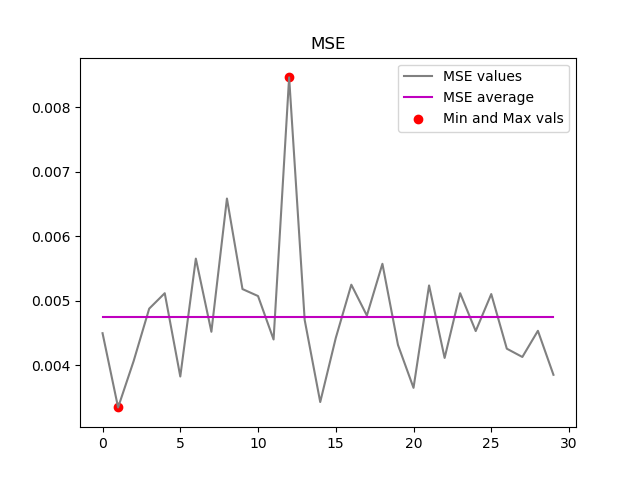

In [70]:
plot_mse(mse_list_2000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 70us/step
MSE: 0.003595797009766102


<IPython.core.display.Javascript object>


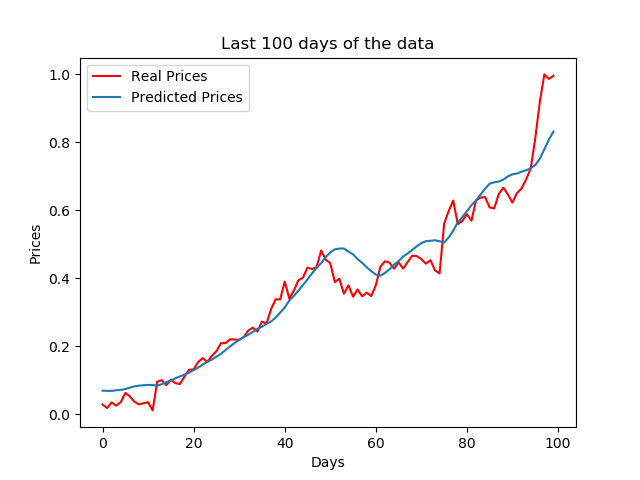

In [71]:
model5_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 47us/step
MSE: 0.0031284022089093926


<IPython.core.display.Javascript object>


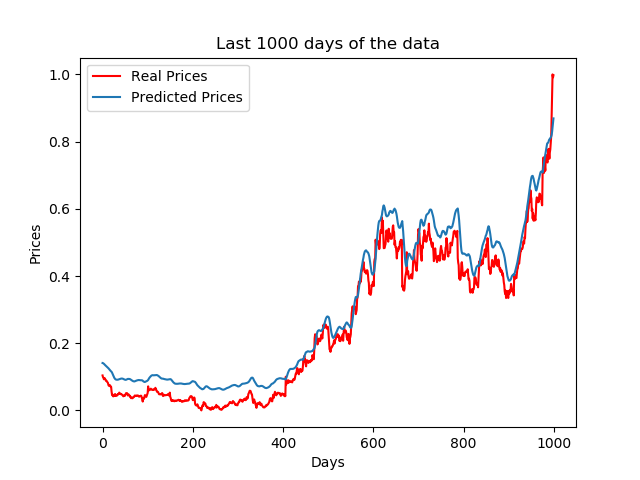

In [72]:
model5_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 42us/step
MSE: 0.0023001551078632473


<IPython.core.display.Javascript object>


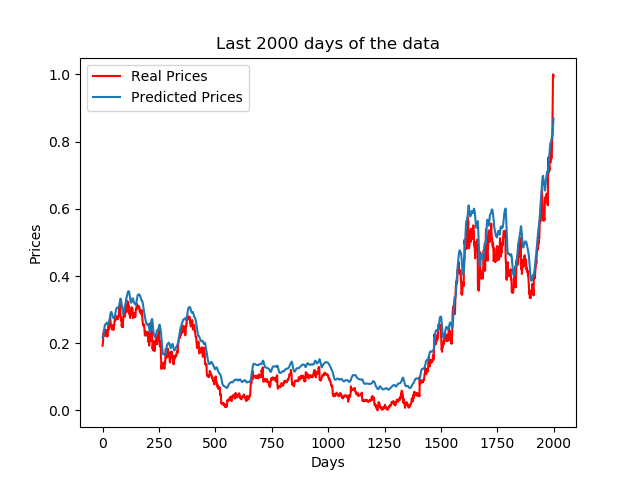

In [73]:
model5_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 6

## Training model 6:

**(2000 input samples extracted, 50% training and 50% testing)**

In [74]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_50[epoch].shape)
    print(y_train_all_2000_50[epoch].shape)
    
    # fit the model to the current data
    model_2000_50.fit(X_train_all_2000_50[epoch],
                      y_train_all_2000_50[epoch],
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(142, 50, 1)
(142, 1)
Epoch 1/70
142/142 [==============================] - 1s 7ms/step - loss: 0.3020
Epoch 2/70
142/142 [==============================] - 0s 190us/step - loss: 0.2984
Epoch 3/70
142/142 [==============================] - 0s 155us/step - loss: 0.2935
Epoch 4/70
142/142 [==============================] - 0s 169us/step - loss: 0.2886
Epoch 5/70
142/142 [==============================] - 0s 147us/step - loss: 0.2838
Epoch 6/70
142/142 [==============================] - 0s 147us/step - loss: 0.2791
Epoch 7/70
142/142 [==============================] - 0s 140us/step - loss: 0.2744
Epoch 8/70
142/142 [==============================] - 0s 140us/step - loss: 0.2697
Epoch 9/70
142/142 [==============================] - 0s 183us/step - loss: 0.2650
Epoch 10/70
142/142 [==============================] - 0s 154us/step - loss: 0.2604
Epoch 11/70
142/142 [==============================] - 0s 147us/step - loss: 0.2559
Epoch 12/70
142/142 [==============================] - 0s

149/149 [==============================] - 0s 100us/step - loss: 0.0266
Epoch 29/70
149/149 [==============================] - 0s 141us/step - loss: 0.0262
Epoch 30/70
149/149 [==============================] - 0s 134us/step - loss: 0.0257
Epoch 31/70
149/149 [==============================] - 0s 94us/step - loss: 0.0252
Epoch 32/70
149/149 [==============================] - 0s 100us/step - loss: 0.0248
Epoch 33/70
149/149 [==============================] - 0s 120us/step - loss: 0.0244
Epoch 34/70
149/149 [==============================] - 0s 120us/step - loss: 0.0241
Epoch 35/70
149/149 [==============================] - 0s 120us/step - loss: 0.0237
Epoch 36/70
149/149 [==============================] - 0s 100us/step - loss: 0.0234
Epoch 37/70
149/149 [==============================] - 0s 94us/step - loss: 0.0231
Epoch 38/70
149/149 [==============================] - 0s 114us/step - loss: 0.0228
Epoch 39/70
149/149 [==============================] - 0s 107us/step - loss: 0.0225
Epoch 

153/153 [==============================] - 0s 91us/step - loss: 0.0130
Epoch 57/70
153/153 [==============================] - 0s 85us/step - loss: 0.0129
Epoch 58/70
153/153 [==============================] - 0s 85us/step - loss: 0.0128
Epoch 59/70
153/153 [==============================] - 0s 85us/step - loss: 0.0128
Epoch 60/70
153/153 [==============================] - 0s 85us/step - loss: 0.0127
Epoch 61/70
153/153 [==============================] - 0s 85us/step - loss: 0.0126
Epoch 62/70
153/153 [==============================] - 0s 98us/step - loss: 0.0126
Epoch 63/70
153/153 [==============================] - 0s 78us/step - loss: 0.0125
Epoch 64/70
153/153 [==============================] - 0s 111us/step - loss: 0.0124
Epoch 65/70
153/153 [==============================] - 0s 91us/step - loss: 0.0124
Epoch 66/70
153/153 [==============================] - 0s 85us/step - loss: 0.0123
Epoch 67/70
153/153 [==============================] - 0s 111us/step - loss: 0.0122
Epoch 68/70
15

Epoch 14/70
117/117 [==============================] - 0s 341us/step - loss: 0.0097
Epoch 15/70
117/117 [==============================] - 0s 332us/step - loss: 0.0096
Epoch 16/70
117/117 [==============================] - 0s 324us/step - loss: 0.0096
Epoch 17/70
117/117 [==============================] - 0s 341us/step - loss: 0.0096
Epoch 18/70
117/117 [==============================] - 0s 341us/step - loss: 0.0096
Epoch 19/70
117/117 [==============================] - 0s 307us/step - loss: 0.0095
Epoch 20/70
117/117 [==============================] - 0s 375us/step - loss: 0.0095
Epoch 21/70
117/117 [==============================] - 0s 426us/step - loss: 0.0095
Epoch 22/70
117/117 [==============================] - 0s 349us/step - loss: 0.0095
Epoch 23/70
117/117 [==============================] - 0s 298us/step - loss: 0.0095
Epoch 24/70
117/117 [==============================] - 0s 401us/step - loss: 0.0094
Epoch 25/70
117/117 [==============================] - 0s 298us/step - loss:

Epoch 42/70
151/151 [==============================] - 0s 112us/step - loss: 0.0077
Epoch 43/70
151/151 [==============================] - 0s 112us/step - loss: 0.0077
Epoch 44/70
151/151 [==============================] - 0s 119us/step - loss: 0.0077
Epoch 45/70
151/151 [==============================] - 0s 119us/step - loss: 0.0077
Epoch 46/70
151/151 [==============================] - 0s 139us/step - loss: 0.0076
Epoch 47/70
151/151 [==============================] - 0s 106us/step - loss: 0.0076
Epoch 48/70
151/151 [==============================] - 0s 92us/step - loss: 0.0076
Epoch 49/70
151/151 [==============================] - 0s 92us/step - loss: 0.0076
Epoch 50/70
151/151 [==============================] - 0s 99us/step - loss: 0.0076
Epoch 51/70
151/151 [==============================] - 0s 99us/step - loss: 0.0076
Epoch 52/70
151/151 [==============================] - 0s 106us/step - loss: 0.0076
Epoch 53/70
151/151 [==============================] - 0s 106us/step - loss: 0.0

Epoch 70/70
128/128 [==============================] - 0s 242us/step - loss: 0.0073
epoch=7
(145, 45, 1)
(145, 1)
Epoch 1/70
145/145 [==============================] - 0s 131us/step - loss: 0.0068
Epoch 2/70
145/145 [==============================] - 0s 138us/step - loss: 0.0068
Epoch 3/70
145/145 [==============================] - 0s 131us/step - loss: 0.0067
Epoch 4/70
145/145 [==============================] - 0s 151us/step - loss: 0.0067
Epoch 5/70
145/145 [==============================] - 0s 131us/step - loss: 0.0067
Epoch 6/70
145/145 [==============================] - 0s 144us/step - loss: 0.0067
Epoch 7/70
145/145 [==============================] - 0s 131us/step - loss: 0.0067
Epoch 8/70
145/145 [==============================] - 0s 165us/step - loss: 0.0067
Epoch 9/70
145/145 [==============================] - 0s 151us/step - loss: 0.0067
Epoch 10/70
145/145 [==============================] - 0s 172us/step - loss: 0.0066
Epoch 11/70
145/145 [==============================] - 

Epoch 28/70
160/160 [==============================] - 0s 56us/step - loss: 0.0065
Epoch 29/70
160/160 [==============================] - 0s 44us/step - loss: 0.0065
Epoch 30/70
160/160 [==============================] - 0s 62us/step - loss: 0.0065
Epoch 31/70
160/160 [==============================] - 0s 56us/step - loss: 0.0064
Epoch 32/70
160/160 [==============================] - 0s 50us/step - loss: 0.0064
Epoch 33/70
160/160 [==============================] - 0s 62us/step - loss: 0.0064
Epoch 34/70
160/160 [==============================] - 0s 56us/step - loss: 0.0064
Epoch 35/70
160/160 [==============================] - 0s 50us/step - loss: 0.0064
Epoch 36/70
160/160 [==============================] - 0s 50us/step - loss: 0.0064
Epoch 37/70
160/160 [==============================] - 0s 62us/step - loss: 0.0064
Epoch 38/70
160/160 [==============================] - 0s 50us/step - loss: 0.0064
Epoch 39/70
160/160 [==============================] - 0s 56us/step - loss: 0.0064
Epoc

Epoch 56/70
120/120 [==============================] - 0s 266us/step - loss: 0.0068
Epoch 57/70
120/120 [==============================] - 0s 391us/step - loss: 0.0068
Epoch 58/70
120/120 [==============================] - 0s 291us/step - loss: 0.0068
Epoch 59/70
120/120 [==============================] - 0s 308us/step - loss: 0.0068
Epoch 60/70
120/120 [==============================] - 0s 299us/step - loss: 0.0068
Epoch 61/70
120/120 [==============================] - 0s 332us/step - loss: 0.0068
Epoch 62/70
120/120 [==============================] - 0s 332us/step - loss: 0.0068
Epoch 63/70
120/120 [==============================] - 0s 308us/step - loss: 0.0068
Epoch 64/70
120/120 [==============================] - 0s 316us/step - loss: 0.0068
Epoch 65/70
120/120 [==============================] - 0s 399us/step - loss: 0.0068
Epoch 66/70
120/120 [==============================] - 0s 839us/step - loss: 0.0068
Epoch 67/70
120/120 [==============================] - 0s 507us/step - loss:

140/140 [==============================] - 0s 164us/step - loss: 0.0050
Epoch 14/70
140/140 [==============================] - 0s 164us/step - loss: 0.0050
Epoch 15/70
140/140 [==============================] - 0s 171us/step - loss: 0.0050
Epoch 16/70
140/140 [==============================] - 0s 164us/step - loss: 0.0050
Epoch 17/70
140/140 [==============================] - 0s 185us/step - loss: 0.0050
Epoch 18/70
140/140 [==============================] - 0s 235us/step - loss: 0.0050
Epoch 19/70
140/140 [==============================] - 0s 214us/step - loss: 0.0050
Epoch 20/70
140/140 [==============================] - 0s 207us/step - loss: 0.0050
Epoch 21/70
140/140 [==============================] - 0s 185us/step - loss: 0.0049
Epoch 22/70
140/140 [==============================] - 0s 157us/step - loss: 0.0049
Epoch 23/70
140/140 [==============================] - 0s 185us/step - loss: 0.0049
Epoch 24/70
140/140 [==============================] - 0s 199us/step - loss: 0.0049
Epoc

Epoch 41/70
161/161 [==============================] - 0s 37us/step - loss: 0.0056
Epoch 42/70
161/161 [==============================] - 0s 37us/step - loss: 0.0056
Epoch 43/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 44/70
161/161 [==============================] - 0s 37us/step - loss: 0.0056
Epoch 45/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 46/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 47/70
161/161 [==============================] - 0s 62us/step - loss: 0.0056
Epoch 48/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 49/70
161/161 [==============================] - 0s 62us/step - loss: 0.0056
Epoch 50/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 51/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoch 52/70
161/161 [==============================] - 0s 43us/step - loss: 0.0056
Epoc

Epoch 69/70
122/122 [==============================] - 0s 319us/step - loss: 0.0047
Epoch 70/70
122/122 [==============================] - 0s 335us/step - loss: 0.0047
epoch=14
(121, 92, 1)
(121, 1)
Epoch 1/70
121/121 [==============================] - 0s 453us/step - loss: 0.0058
Epoch 2/70
121/121 [==============================] - 0s 354us/step - loss: 0.0058
Epoch 3/70
121/121 [==============================] - 0s 346us/step - loss: 0.0058
Epoch 4/70
121/121 [==============================] - 0s 379us/step - loss: 0.0058
Epoch 5/70
121/121 [==============================] - 0s 396us/step - loss: 0.0058
Epoch 6/70
121/121 [==============================] - 0s 387us/step - loss: 0.0058
Epoch 7/70
121/121 [==============================] - 0s 338us/step - loss: 0.0058
Epoch 8/70
121/121 [==============================] - 0s 371us/step - loss: 0.0058
Epoch 9/70
121/121 [==============================] - 0s 462us/step - loss: 0.0058
Epoch 10/70
121/121 [==============================] -

Epoch 27/70
155/155 [==============================] - 0s 97us/step - loss: 0.0053
Epoch 28/70
155/155 [==============================] - 0s 90us/step - loss: 0.0053
Epoch 29/70
155/155 [==============================] - 0s 77us/step - loss: 0.0053
Epoch 30/70
155/155 [==============================] - 0s 84us/step - loss: 0.0053
Epoch 31/70
155/155 [==============================] - 0s 71us/step - loss: 0.0052
Epoch 32/70
155/155 [==============================] - 0s 71us/step - loss: 0.0052
Epoch 33/70
155/155 [==============================] - 0s 90us/step - loss: 0.0052
Epoch 34/70
155/155 [==============================] - 0s 77us/step - loss: 0.0052
Epoch 35/70
155/155 [==============================] - 0s 64us/step - loss: 0.0051
Epoch 36/70
155/155 [==============================] - 0s 84us/step - loss: 0.0051
Epoch 37/70
155/155 [==============================] - 0s 77us/step - loss: 0.0051
Epoch 38/70
155/155 [==============================] - 0s 77us/step - loss: 0.0051
Epoc

Epoch 56/70
158/158 [==============================] - 0s 51us/step - loss: 0.0051
Epoch 57/70
158/158 [==============================] - 0s 69us/step - loss: 0.0051
Epoch 58/70
158/158 [==============================] - 0s 82us/step - loss: 0.0051
Epoch 59/70
158/158 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 60/70
158/158 [==============================] - 0s 69us/step - loss: 0.0051
Epoch 61/70
158/158 [==============================] - 0s 51us/step - loss: 0.0051
Epoch 62/70
158/158 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 63/70
158/158 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 64/70
158/158 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 65/70
158/158 [==============================] - 0s 69us/step - loss: 0.0051
Epoch 66/70
158/158 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 67/70
158/158 [==============================] - 0s 69us/step - loss: 0.0051
Epoc

Epoch 14/70
131/131 [==============================] - 0s 221us/step - loss: 0.0051
Epoch 15/70
131/131 [==============================] - 0s 228us/step - loss: 0.0051
Epoch 16/70
131/131 [==============================] - 0s 251us/step - loss: 0.0051
Epoch 17/70
131/131 [==============================] - 0s 228us/step - loss: 0.0051
Epoch 18/70
131/131 [==============================] - 0s 335us/step - loss: 0.0051
Epoch 19/70
131/131 [==============================] - 0s 221us/step - loss: 0.0051
Epoch 20/70
131/131 [==============================] - 0s 213us/step - loss: 0.0051
Epoch 21/70
131/131 [==============================] - 0s 274us/step - loss: 0.0051
Epoch 22/70
131/131 [==============================] - 0s 259us/step - loss: 0.0051
Epoch 23/70
131/131 [==============================] - 0s 266us/step - loss: 0.0051
Epoch 24/70
131/131 [==============================] - 0s 228us/step - loss: 0.0051
Epoch 25/70
131/131 [==============================] - 0s 236us/step - loss:

Epoch 42/70
155/155 [==============================] - 0s 97us/step - loss: 0.0047
Epoch 43/70
155/155 [==============================] - 0s 90us/step - loss: 0.0047
Epoch 44/70
155/155 [==============================] - 0s 77us/step - loss: 0.0047
Epoch 45/70
155/155 [==============================] - 0s 71us/step - loss: 0.0047
Epoch 46/70
155/155 [==============================] - 0s 71us/step - loss: 0.0047
Epoch 47/70
155/155 [==============================] - 0s 77us/step - loss: 0.0047
Epoch 48/70
155/155 [==============================] - 0s 90us/step - loss: 0.0047
Epoch 49/70
155/155 [==============================] - 0s 97us/step - loss: 0.0047
Epoch 50/70
155/155 [==============================] - 0s 103us/step - loss: 0.0047
Epoch 51/70
155/155 [==============================] - 0s 84us/step - loss: 0.0047
Epoch 52/70
155/155 [==============================] - 0s 84us/step - loss: 0.0047
Epoch 53/70
155/155 [==============================] - 0s 90us/step - loss: 0.0047
Epo

epoch=21
(121, 92, 1)
(121, 1)
Epoch 1/70
121/121 [==============================] - 0s 404us/step - loss: 0.0057
Epoch 2/70
121/121 [==============================] - 0s 396us/step - loss: 0.0055
Epoch 3/70
121/121 [==============================] - 0s 288us/step - loss: 0.0053
Epoch 4/70
121/121 [==============================] - 0s 321us/step - loss: 0.0049
Epoch 5/70
121/121 [==============================] - 0s 437us/step - loss: 0.0045
Epoch 6/70
121/121 [==============================] - 0s 297us/step - loss: 0.0042
Epoch 7/70
121/121 [==============================] - 0s 371us/step - loss: 0.0039
Epoch 8/70
121/121 [==============================] - 0s 338us/step - loss: 0.0037
Epoch 9/70
121/121 [==============================] - 0s 371us/step - loss: 0.0035
Epoch 10/70
121/121 [==============================] - 0s 371us/step - loss: 0.0035
Epoch 11/70
121/121 [==============================] - 0s 371us/step - loss: 0.0035
Epoch 12/70
121/121 [==============================] -

134/134 [==============================] - 0s 223us/step - loss: 0.0044
Epoch 29/70
134/134 [==============================] - 0s 231us/step - loss: 0.0044
Epoch 30/70
134/134 [==============================] - 0s 216us/step - loss: 0.0044
Epoch 31/70
134/134 [==============================] - 0s 223us/step - loss: 0.0044
Epoch 32/70
134/134 [==============================] - 0s 261us/step - loss: 0.0044
Epoch 33/70
134/134 [==============================] - 0s 223us/step - loss: 0.0044
Epoch 34/70
134/134 [==============================] - 0s 253us/step - loss: 0.0044
Epoch 35/70
134/134 [==============================] - 0s 194us/step - loss: 0.0044
Epoch 36/70
134/134 [==============================] - 0s 268us/step - loss: 0.0044
Epoch 37/70
134/134 [==============================] - 0s 275us/step - loss: 0.0044
Epoch 38/70
134/134 [==============================] - 0s 231us/step - loss: 0.0044
Epoch 39/70
134/134 [==============================] - 0s 268us/step - loss: 0.0044
Epoc

155/155 [==============================] - 0s 84us/step - loss: 0.0040
Epoch 57/70
155/155 [==============================] - 0s 71us/step - loss: 0.0039
Epoch 58/70
155/155 [==============================] - 0s 116us/step - loss: 0.0039
Epoch 59/70
155/155 [==============================] - 0s 64us/step - loss: 0.0039
Epoch 60/70
155/155 [==============================] - 0s 71us/step - loss: 0.0039
Epoch 61/70
155/155 [==============================] - 0s 77us/step - loss: 0.0039
Epoch 62/70
155/155 [==============================] - 0s 77us/step - loss: 0.0039
Epoch 63/70
155/155 [==============================] - 0s 71us/step - loss: 0.0039
Epoch 64/70
155/155 [==============================] - 0s 84us/step - loss: 0.0039
Epoch 65/70
155/155 [==============================] - 0s 71us/step - loss: 0.0039
Epoch 66/70
155/155 [==============================] - 0s 77us/step - loss: 0.0039
Epoch 67/70
155/155 [==============================] - 0s 103us/step - loss: 0.0039
Epoch 68/70
15

122/122 [==============================] - 0s 311us/step - loss: 0.0042
Epoch 15/70
122/122 [==============================] - 0s 311us/step - loss: 0.0042
Epoch 16/70
122/122 [==============================] - 0s 311us/step - loss: 0.0042
Epoch 17/70
122/122 [==============================] - 0s 360us/step - loss: 0.0042
Epoch 18/70
122/122 [==============================] - 0s 319us/step - loss: 0.0042
Epoch 19/70
122/122 [==============================] - 0s 343us/step - loss: 0.0042
Epoch 20/70
122/122 [==============================] - 0s 384us/step - loss: 0.0041
Epoch 21/70
122/122 [==============================] - 0s 343us/step - loss: 0.0041
Epoch 22/70
122/122 [==============================] - 0s 466us/step - loss: 0.0041
Epoch 23/70
122/122 [==============================] - 0s 343us/step - loss: 0.0041
Epoch 24/70
122/122 [==============================] - 0s 311us/step - loss: 0.0041
Epoch 25/70
122/122 [==============================] - 0s 311us/step - loss: 0.0040
Epoc

Epoch 42/70
134/134 [==============================] - 0s 268us/step - loss: 0.0039
Epoch 43/70
134/134 [==============================] - 0s 238us/step - loss: 0.0039
Epoch 44/70
134/134 [==============================] - 0s 283us/step - loss: 0.0039
Epoch 45/70
134/134 [==============================] - 0s 253us/step - loss: 0.0038
Epoch 46/70
134/134 [==============================] - 0s 208us/step - loss: 0.0038
Epoch 47/70
134/134 [==============================] - 0s 231us/step - loss: 0.0038
Epoch 48/70
134/134 [==============================] - 0s 223us/step - loss: 0.0038
Epoch 49/70
134/134 [==============================] - 0s 261us/step - loss: 0.0038
Epoch 50/70
134/134 [==============================] - 0s 201us/step - loss: 0.0038
Epoch 51/70
134/134 [==============================] - 0s 246us/step - loss: 0.0038
Epoch 52/70
134/134 [==============================] - 0s 313us/step - loss: 0.0038
Epoch 53/70
134/134 [==============================] - 0s 216us/step - loss:

Epoch 70/70
127/127 [==============================] - 0s 314us/step - loss: 0.0037
epoch=28
(145, 44, 1)
(145, 1)
Epoch 1/70
145/145 [==============================] - 0s 144us/step - loss: 0.0035
Epoch 2/70
145/145 [==============================] - 0s 172us/step - loss: 0.0035
Epoch 3/70
145/145 [==============================] - 0s 165us/step - loss: 0.0035
Epoch 4/70
145/145 [==============================] - 0s 151us/step - loss: 0.0035
Epoch 5/70
145/145 [==============================] - 0s 186us/step - loss: 0.0035
Epoch 6/70
145/145 [==============================] - 0s 131us/step - loss: 0.0035
Epoch 7/70
145/145 [==============================] - 0s 179us/step - loss: 0.0035
Epoch 8/70
145/145 [==============================] - 0s 179us/step - loss: 0.0035
Epoch 9/70
145/145 [==============================] - 0s 158us/step - loss: 0.0035
Epoch 10/70
145/145 [==============================] - 0s 186us/step - loss: 0.0035
Epoch 11/70
145/145 [==============================] -

143/143 [==============================] - 0s 139us/step - loss: 0.0031
Epoch 28/70
143/143 [==============================] - 0s 139us/step - loss: 0.0031
Epoch 29/70
143/143 [==============================] - 0s 181us/step - loss: 0.0031
Epoch 30/70
143/143 [==============================] - 0s 153us/step - loss: 0.0031
Epoch 31/70
143/143 [==============================] - 0s 133us/step - loss: 0.0031
Epoch 32/70
143/143 [==============================] - 0s 384us/step - loss: 0.0031
Epoch 33/70
143/143 [==============================] - 0s 356us/step - loss: 0.0031
Epoch 34/70
143/143 [==============================] - 0s 258us/step - loss: 0.0031
Epoch 35/70
143/143 [==============================] - 0s 167us/step - loss: 0.0031
Epoch 36/70
143/143 [==============================] - 0s 160us/step - loss: 0.0031
Epoch 37/70
143/143 [==============================] - 0s 209us/step - loss: 0.0031
Epoch 38/70
143/143 [==============================] - 0s 188us/step - loss: 0.0031
Epoc

## Testing model 6:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_50, X_test_all_2000_50, y_test_all_2000_50)

In [76]:
mse_list_2000_50 = mse_list(model_2000_50, X_test_all_2000_50, y_test_all_2000_50, lengths)

Max mse: 0.007033386794121369 (related window: 14)
Min mse: 0.002904440916609019 (related window: 80)
Average mse: 0.0040237743156621136


<IPython.core.display.Javascript object>


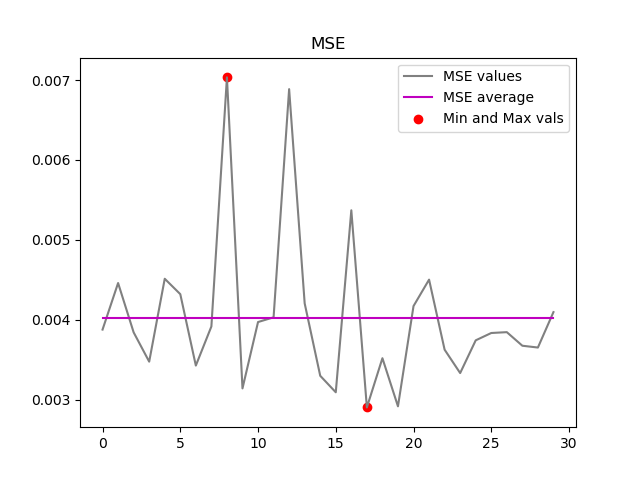

In [77]:
plot_mse(mse_list_2000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 70us/step
MSE: 0.0027707679755985736


<IPython.core.display.Javascript object>


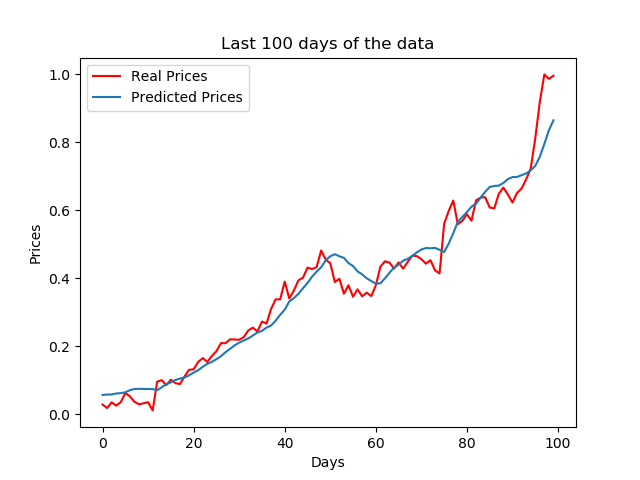

In [78]:
model6_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 51us/step
MSE: 0.0017076808293350041


<IPython.core.display.Javascript object>


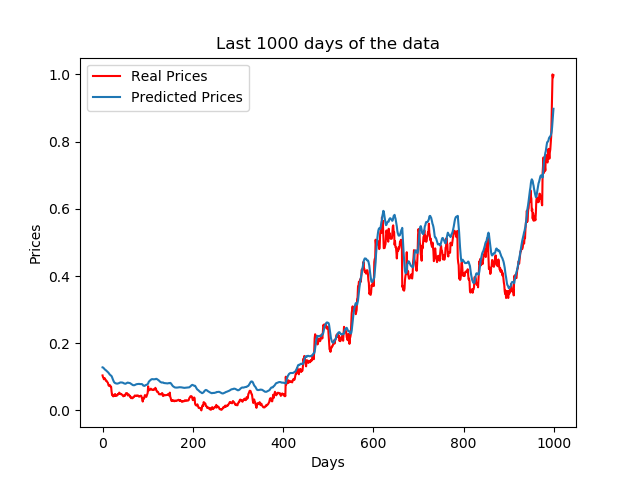

In [79]:
model6_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 45us/step
MSE: 0.001177943759248592


<IPython.core.display.Javascript object>


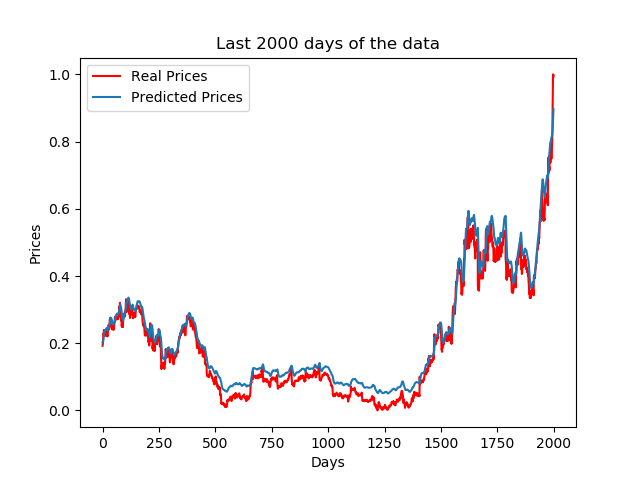

In [80]:
model6_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Comparing Models

## Visually:

Prepare the lists that are needed as parameters for the functions that will be used.

In [81]:
all_test_mse_lists = [mse_list_100_70, # list of MSE values for the Model 1 on Testing data
                     mse_list_100_50, # list of MSE values for the Model 2 on Testing data
                     mse_list_1000_70, # list of MSE values for the Model 3 on Testing data
                     mse_list_1000_50, # list of MSE values for the Model 4 on Testing data
                     mse_list_2000_70, # list of MSE values for the Model 5 on Testing data
                     mse_list_2000_70 # list of MSE values for the Model 6 on Testing data
                    ]
# MSE for each model on the 100 saved unseen input sample
all_100_mse_list = [model1_100, model2_100, model3_100, model4_100, model5_100, model6_100]
# MSE for each model on the 1000 saved unseen input sample
all_1000_mse_list = [model1_1000, model2_1000, model3_1000, model4_1000, model5_1000, model6_1000]
# MSE for each model on the 2000 saved unseen input sample
all_2000_mse_list = [model1_2000, model2_2000, model3_2000, model4_2000, model5_2000, model6_2000]

In [82]:
x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

## Plot MSE for models on testing data

Concretely, three barplots will be plotted showing the minimum, maximum and average MSE values, respectively, on the testing data.

<IPython.core.display.Javascript object>


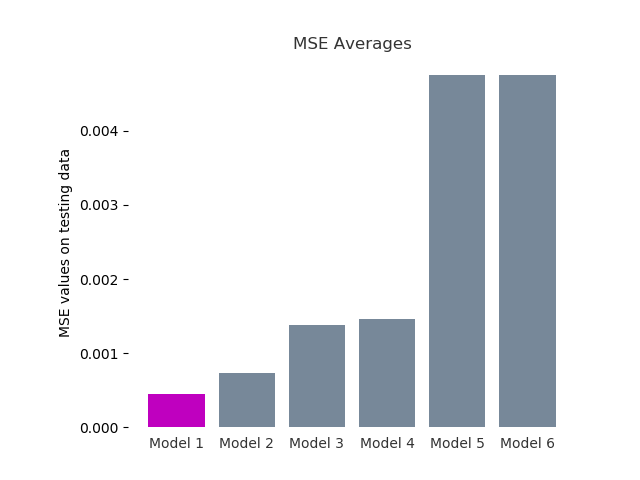

<IPython.core.display.Javascript object>


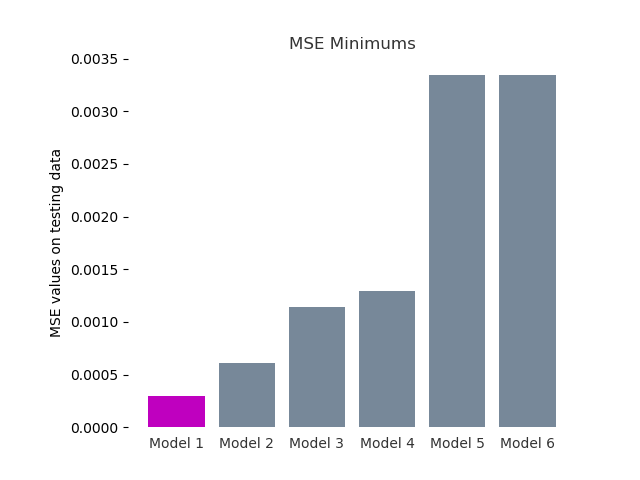

<IPython.core.display.Javascript object>


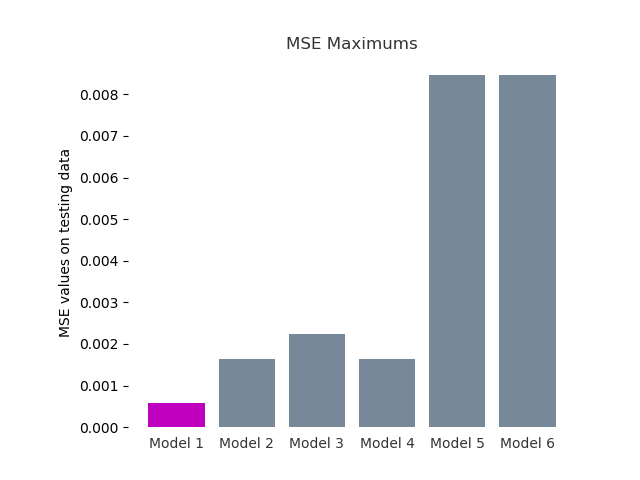

In [85]:
visualize_models_on_testing_data(all_test_mse_lists)

## Plot MSE for models on last 100 days

<IPython.core.display.Javascript object>


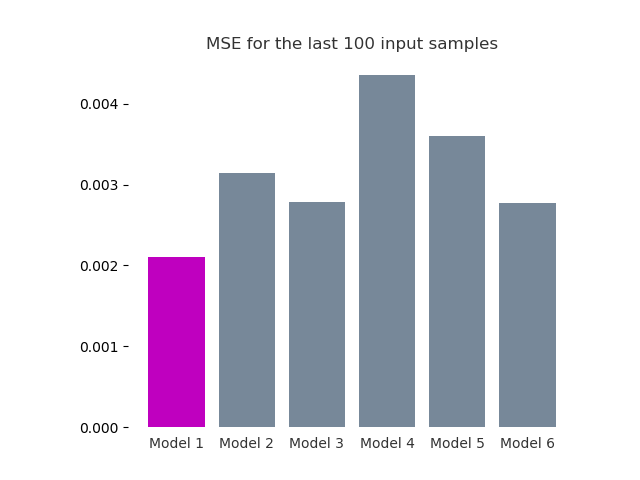

In [86]:
barplot(all_100_mse_list, x_ticks_labels, title='MSE for the last 100 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 1000 days

<IPython.core.display.Javascript object>


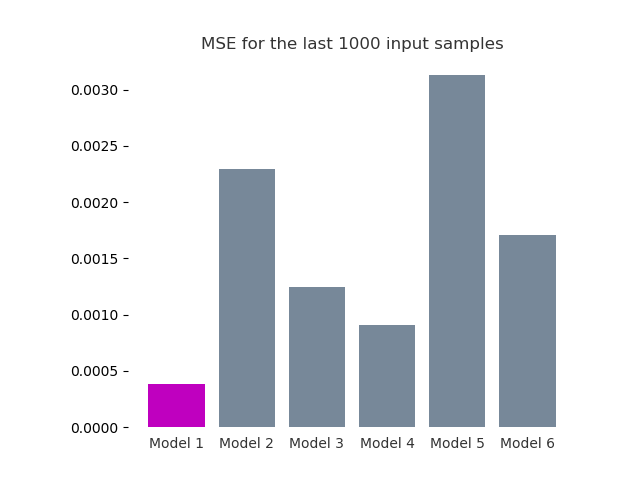

In [87]:
barplot(all_1000_mse_list, x_ticks_labels, title='MSE for the last 1000 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 2000 days

<IPython.core.display.Javascript object>


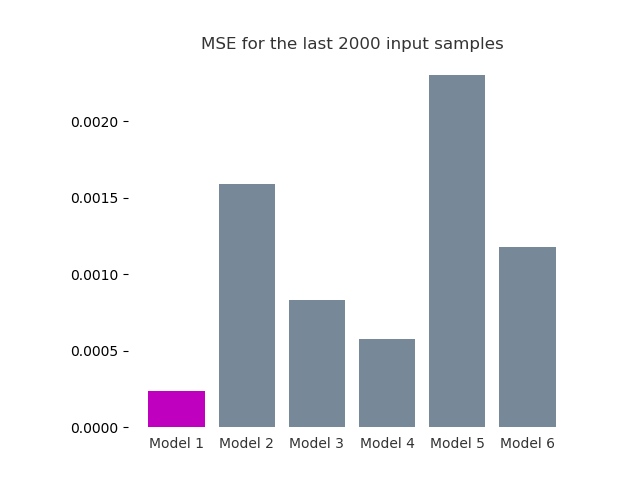

In [88]:
barplot(all_2000_mse_list, x_ticks_labels, title='MSE for the last 2000 input samples', 
        remove_ticks=True, remove_frame=True)

# Tabularly

Prepare the lists that are needed as parameters for the functions that will be used.

In [89]:
models = [model_100_70, model_100_50, model_1000_70, model_1000_50, model_2000_70, model_2000_50]
# Each sample for the last (100, 1000, and 2000) days:
X_test_lists = [X_test_sample_100, X_test_sample_1000, X_test_sample_2000]
y_test_lists = [y_test_sample_100, y_test_sample_1000, y_test_sample_2000]

In [90]:
models_names =  ['model_100_70','model_100_50','model_1000_70','model_1000_50','model_2000_70','model_2000_50']

In [91]:
mse_on_test_data = [ mse_list_100_70, mse_list_100_50, mse_list_1000_70, mse_list_1000_50, 
                    mse_list_2000_70, mse_list_2000_50]

## MSE on testing data

Evaluate each model's performance on each (X,y) pair of Numpy arrays (each generated with a different length of sequences) in the testing data.

In [92]:
mse_on_test_df = mse_on_testing_data_df(mse_on_test_data, models_names, lengths)
mse_on_test_df

model_100_70  model_100_50  model_1000_70  model_1000_50  \
50           0.000448      0.000624       0.001175       0.001453   
36           0.000501      0.000712       0.001314       0.001397   
29           0.000501      0.000727       0.001143       0.001438   
70           0.000368      0.000655       0.001387       0.001495   
100          0.000369      0.000672       0.001250       0.001383   
33           0.000408      0.000752       0.001312       0.001432   
78           0.000403      0.000701       0.001315       0.001380   
45           0.000407      0.000651       0.001308       0.001383   
14           0.000299      0.000954       0.001969       0.001432   
94           0.000443      0.000646       0.001332       0.001421   
55           0.000373      0.000647       0.001238       0.001354   
55           0.000495      0.000734       0.001299       0.001420   
12           0.000582      0.001643       0.002243       0.001642   
90           0.000380      0.000648       0.001365       0.001460   
92           0.000438      0.000652       0.001392       0.001544   
24           0.000572      0.000710       0.001365       0.001391   
18           0.000470      0.000614       0.001596       0.001501   
80           0.000382      0.000686       0.001424       0.001502   
73           0.000457      0.000637       0.001439       0.001467   
24           0.000405      0.000719       0.001175       0.001505   
20           0.000501      0.000685       0.001292       0.001412   
92           0.000382      0.000722       0.001363       0.001540   
66           0.000343      0.000708       0.001410       0.001607   
24           0.000479      0.000760       0.001370       0.001427   
22           0.000555      0.000701       0.001268       0.001293   
90           0.000501      0.000678       0.001234       0.001611   
66           0.000488      0.000682       0.001344       0.001424   
81           0.000494      0.000740       0.001168       0.001540   
44           0.000443      0.000628       0.001335       0.001479   
49           0.000408      0.000680       0.001538       0.001466   
AVG MSE      0.000443      0.000726       0.001379       0.001460   
MAX MSE      0.000582      0.001643       0.002243       0.001642   
MIN MSE      0.000299      0.000614       0.001143       0.001293   

         model_2000_70  model_2000_50  
50            0.004495       0.003878  
36            0.003343       0.004461  
29            0.004063       0.003844  
70            0.004875       0.003477  
100           0.005114       0.004514  
33            0.003823       0.004321  
78            0.005651       0.003428  
45            0.004517       0.003917  
14            0.006582       0.007033  
94            0.005178       0.003143  
55            0.005070       0.003973  
55            0.004397       0.004032  
12            0.008460       0.006886  
90            0.004700       0.004206  
92            0.003427       0.003301  
24            0.004420       0.003094  
18            0.005246       0.005371  
80            0.004768       0.002904  
73            0.005570       0.003520  
24            0.004313       0.002919  
20            0.003647       0.004173  
92            0.005235       0.004503  
66            0.004111       0.003627  
24            0.005114       0.003334  
22            0.004527       0.003744  
90            0.005101       0.003836  
66            0.004254       0.003846  
81            0.004126       0.003676  
44            0.004532       0.003654  
49            0.003850       0.004097  
AVG MSE       0.004750       0.004024  
MAX MSE       0.008460       0.007033  
MIN MSE       0.003343       0.002904

## MSE on the last samples

Evaluate each model's performance on each of the last 100, 1000 and 2000 days (totally unseen data).

In [93]:
mse_last_samples_df = mse_on_samples_df(models, X_test_lists, y_test_lists, 
                                        ['last_100_days','last_1000_days','last_2000_days'], models_names)
mse_last_samples_df

model  last_100_days  last_1000_days  last_2000_days
0   model_100_70       0.002104        0.000381        0.000235
1   model_100_50       0.003148        0.002291        0.001586
2  model_1000_70       0.002779        0.001250        0.000832
3  model_1000_50       0.004352        0.000908        0.000578
4  model_2000_70       0.003596        0.003128        0.002300
5  model_2000_50       0.002771        0.001708        0.001178

# Saving the models

In [94]:
main_path = "E:\\Senior-Year  graduation project\\Latest results and models - 26-May-2019\\"

In [95]:
path_100_70 = "AMD models\\model_100_70.h5"
path_100_50 = "AMD models\\model_100_50.h5"

path_1000_70 = "AMD models\\model_1000_70.h5"
path_1000_50 = "AMD models\\model_1000_50.h5"

path_2000_70 = "AMD models\\model_2000_70.h5"
path_2000_50 = "AMD models\\model_2000_50.h5"

In [96]:
model_100_70.save(main_path+path_100_70)
model_100_50.save(main_path+path_100_50)

model_1000_70.save(main_path+path_1000_70)
model_1000_50.save(main_path+path_1000_50)

model_2000_70.save(main_path+path_2000_70)
model_2000_50.save(main_path+path_2000_50)

## Saving the resulted tables

In [97]:
mse_on_test_df.to_csv(main_path+"AMD MSE tables\\mse_on_testing_data.csv")
mse_last_samples_df.to_csv(main_path+"AMD MSE tables\\mse_on_last_samples.csv")